In [2]:
import os
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from breakhisfile import BreakhisDataset
import torch.optim as optim
import time
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
import copy

2023-03-31 10:13:13.931079: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-31 10:13:15.673197: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-31 10:13:15.673271: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-31 10:13:15.673278: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [4]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Resize([512, 384])])

batch_size = 32

train_dataset = BreakhisDataset(path='/home/ardhendu/Desktop/breakhis_classification/data-train.csv',transforms=transform )
val_dataset = BreakhisDataset(path='/home/ardhendu/Desktop/breakhis_classification/data-test.csv' ,transforms=transform)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=False)
testloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=False)


device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [5]:
resnet18_new = torchvision.models.resnet18()

In [6]:
resnet18_new.fc = nn.Linear(in_features=512, out_features=4, bias=True)

In [7]:
resnet18_new.to(device)
# print(model)
# exit()
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()

optimizer = optim.AdamW(resnet18_new.parameters(), lr=3e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)

In [8]:
best_acc = 0.0
train_accuracy=[]
train_loss=[]
val_accuracy=[]
val_loss=[]
for epoch in range(1000):  # loop over the dataset multiple times
    t0 = time.time()
    
    running_corrects = 0
    running_loss = 0.0

    for data in tqdm(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = resnet18_new(inputs)
        #print(f' out :{outputs.shape} and label :{labels.shape} and img :{inputs.shape}')
        s_out= F.softmax(outputs)
        _, preds = torch.max(outputs, 1)
        with torch.cuda.amp.autocast():
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).cpu()    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset)
    train_accuracy.append(epoch_acc)
    train_loss.append(epoch_loss)
    writer.add_scalar("Loss/train", epoch_loss, epoch+1)
    writer.add_scalar("Acc/train", epoch_acc, epoch+1)    
    running_test_loss=0
    running_test_correct=0


    for data in tqdm(testloader):
        images, labels = data[0].to(device), data[1].to(device)
        with torch.no_grad():
            outputs = resnet18_new(images)
            s_out= F.softmax(outputs)
        _, predicted = torch.max(outputs.data, 1)
        test_loss= criterion(outputs,labels)
        running_test_loss=test_loss.item()*images.size(0)
        running_test_correct+= torch.sum(predicted == labels.data).cpu()
       
    epoch_val_loss = running_test_loss / len(val_dataset)
    epoch_val_acc = running_test_correct.double() / len(val_dataset) 
    val_accuracy.append(epoch_val_acc)
    val_loss.append(epoch_val_loss)
    writer.add_scalar("Loss/Val", epoch_val_loss, epoch+1)
    writer.add_scalar("Acc/Val", epoch_val_acc, epoch+1)
    print(f"Epoch : {epoch+1} - Train_loss : {epoch_loss:.4f} - Train_Acc: {epoch_acc:.4f} - Val_loss : {epoch_val_loss:.4f} - Val_Acc: {epoch_val_acc:.4f}  - Time: {time.time() - t0}\n")
    if epoch_val_acc > best_acc:
        best_acc = epoch_val_acc
        best_model_wts = copy.deepcopy(resnet18_new.state_dict())
        
#torch.save(best_model_wts, PATH)
print('Finished Training')

  0%|                                                    | 0/40 [00:00<?, ?it/s]/tmp/ipykernel_43043/1489879702.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  s_out= F.softmax(outputs)
  0%|                                                    | 0/18 [00:00<?, ?it/s]/tmp/ipykernel_43043/1489879702.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  s_out= F.softmax(outputs)
100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  7.61it/s]


Epoch : 1 - Train_loss : 0.5138 - Train_Acc: 0.8022 - Val_loss : 0.0005 - Val_Acc: 0.8645  - Time: 7.873028993606567



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.38it/s]


Epoch : 2 - Train_loss : 0.3330 - Train_Acc: 0.8713 - Val_loss : 0.0003 - Val_Acc: 0.8718  - Time: 7.332873344421387



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.39it/s]


Epoch : 3 - Train_loss : 0.3017 - Train_Acc: 0.8791 - Val_loss : 0.0002 - Val_Acc: 0.8791  - Time: 7.329469442367554



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.15it/s]


Epoch : 4 - Train_loss : 0.3271 - Train_Acc: 0.8673 - Val_loss : 0.0003 - Val_Acc: 0.8645  - Time: 7.430402040481567



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.09it/s]


Epoch : 5 - Train_loss : 0.2756 - Train_Acc: 0.8917 - Val_loss : 0.0006 - Val_Acc: 0.8755  - Time: 7.453688383102417



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.27it/s]


Epoch : 6 - Train_loss : 0.2779 - Train_Acc: 0.8862 - Val_loss : 0.0001 - Val_Acc: 0.8718  - Time: 7.391558408737183



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  7.73it/s]


Epoch : 7 - Train_loss : 0.2656 - Train_Acc: 0.8980 - Val_loss : 0.0002 - Val_Acc: 0.8901  - Time: 7.668359041213989



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  7.87it/s]


Epoch : 8 - Train_loss : 0.2456 - Train_Acc: 0.8940 - Val_loss : 0.0001 - Val_Acc: 0.8571  - Time: 7.65777325630188



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.25it/s]


Epoch : 9 - Train_loss : 0.2436 - Train_Acc: 0.9003 - Val_loss : 0.0002 - Val_Acc: 0.9121  - Time: 7.792113542556763



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.25it/s]


Epoch : 10 - Train_loss : 0.2264 - Train_Acc: 0.8987 - Val_loss : 0.0004 - Val_Acc: 0.8755  - Time: 7.467731714248657



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.21it/s]


Epoch : 11 - Train_loss : 0.2135 - Train_Acc: 0.9152 - Val_loss : 0.0001 - Val_Acc: 0.9194  - Time: 7.59668755531311



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.05it/s]


Epoch : 12 - Train_loss : 0.2176 - Train_Acc: 0.9192 - Val_loss : 0.0002 - Val_Acc: 0.9011  - Time: 7.694610118865967



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.29it/s]


Epoch : 13 - Train_loss : 0.2342 - Train_Acc: 0.9027 - Val_loss : 0.0001 - Val_Acc: 0.9231  - Time: 7.828354120254517



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.31it/s]


Epoch : 14 - Train_loss : 0.1948 - Train_Acc: 0.9176 - Val_loss : 0.0001 - Val_Acc: 0.9011  - Time: 7.711364030838013



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.13it/s]


Epoch : 15 - Train_loss : 0.1995 - Train_Acc: 0.9231 - Val_loss : 0.0002 - Val_Acc: 0.9194  - Time: 7.700317859649658



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  7.98it/s]


Epoch : 16 - Train_loss : 0.1726 - Train_Acc: 0.9286 - Val_loss : 0.0005 - Val_Acc: 0.9396  - Time: 7.598491430282593



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  7.97it/s]


Epoch : 17 - Train_loss : 0.1780 - Train_Acc: 0.9254 - Val_loss : 0.0003 - Val_Acc: 0.9212  - Time: 7.633810043334961



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.30it/s]


Epoch : 18 - Train_loss : 0.1784 - Train_Acc: 0.9231 - Val_loss : 0.0003 - Val_Acc: 0.8901  - Time: 7.4914469718933105



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.31it/s]


Epoch : 19 - Train_loss : 0.1789 - Train_Acc: 0.9239 - Val_loss : 0.0001 - Val_Acc: 0.9359  - Time: 7.458186149597168



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.14it/s]


Epoch : 20 - Train_loss : 0.1910 - Train_Acc: 0.9254 - Val_loss : 0.0001 - Val_Acc: 0.9414  - Time: 7.533248424530029



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.23it/s]


Epoch : 21 - Train_loss : 0.1598 - Train_Acc: 0.9364 - Val_loss : 0.0000 - Val_Acc: 0.9396  - Time: 7.467796087265015



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.42it/s]


Epoch : 22 - Train_loss : 0.1379 - Train_Acc: 0.9403 - Val_loss : 0.0001 - Val_Acc: 0.9359  - Time: 7.480411529541016



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.15it/s]


Epoch : 23 - Train_loss : 0.1432 - Train_Acc: 0.9403 - Val_loss : 0.0001 - Val_Acc: 0.9176  - Time: 7.513349294662476



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.25it/s]


Epoch : 24 - Train_loss : 0.1550 - Train_Acc: 0.9349 - Val_loss : 0.0003 - Val_Acc: 0.9066  - Time: 7.516186952590942



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  7.97it/s]


Epoch : 25 - Train_loss : 0.1618 - Train_Acc: 0.9356 - Val_loss : 0.0005 - Val_Acc: 0.9469  - Time: 7.628510236740112



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.37it/s]


Epoch : 26 - Train_loss : 0.1124 - Train_Acc: 0.9529 - Val_loss : 0.0001 - Val_Acc: 0.9432  - Time: 7.588333368301392



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.25it/s]


Epoch : 27 - Train_loss : 0.1157 - Train_Acc: 0.9537 - Val_loss : 0.0000 - Val_Acc: 0.9359  - Time: 7.599279165267944



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  7.97it/s]


Epoch : 28 - Train_loss : 0.1357 - Train_Acc: 0.9490 - Val_loss : 0.0001 - Val_Acc: 0.9084  - Time: 7.711270809173584



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.33it/s]


Epoch : 29 - Train_loss : 0.1386 - Train_Acc: 0.9443 - Val_loss : 0.0003 - Val_Acc: 0.9432  - Time: 7.615065813064575



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.32it/s]


Epoch : 30 - Train_loss : 0.0916 - Train_Acc: 0.9608 - Val_loss : 0.0007 - Val_Acc: 0.9286  - Time: 7.623175144195557



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.08it/s]


Epoch : 31 - Train_loss : 0.1258 - Train_Acc: 0.9537 - Val_loss : 0.0001 - Val_Acc: 0.9139  - Time: 7.679165363311768



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.27it/s]


Epoch : 32 - Train_loss : 0.1115 - Train_Acc: 0.9553 - Val_loss : 0.0002 - Val_Acc: 0.9524  - Time: 7.6639673709869385



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.03it/s]


Epoch : 33 - Train_loss : 0.1027 - Train_Acc: 0.9537 - Val_loss : 0.0001 - Val_Acc: 0.9451  - Time: 7.686239957809448



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  7.81it/s]


Epoch : 34 - Train_loss : 0.0824 - Train_Acc: 0.9710 - Val_loss : 0.0002 - Val_Acc: 0.9341  - Time: 7.7920496463775635



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  7.95it/s]


Epoch : 35 - Train_loss : 0.1050 - Train_Acc: 0.9592 - Val_loss : 0.0001 - Val_Acc: 0.9377  - Time: 7.736690044403076



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.17it/s]


Epoch : 36 - Train_loss : 0.0785 - Train_Acc: 0.9717 - Val_loss : 0.0000 - Val_Acc: 0.9469  - Time: 7.620532274246216



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.12it/s]


Epoch : 37 - Train_loss : 0.1121 - Train_Acc: 0.9600 - Val_loss : 0.0004 - Val_Acc: 0.9505  - Time: 7.6943511962890625



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  7.53it/s]


Epoch : 38 - Train_loss : 0.0639 - Train_Acc: 0.9788 - Val_loss : 0.0003 - Val_Acc: 0.9469  - Time: 7.782700538635254



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.92it/s]


Epoch : 39 - Train_loss : 0.0563 - Train_Acc: 0.9804 - Val_loss : 0.0001 - Val_Acc: 0.9396  - Time: 8.998508930206299



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  7.18it/s]


Epoch : 40 - Train_loss : 0.0424 - Train_Acc: 0.9874 - Val_loss : 0.0000 - Val_Acc: 0.9505  - Time: 8.498290777206421



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.74it/s]


Epoch : 41 - Train_loss : 0.1041 - Train_Acc: 0.9615 - Val_loss : 0.0000 - Val_Acc: 0.8974  - Time: 8.658877611160278



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  7.34it/s]


Epoch : 42 - Train_loss : 0.0936 - Train_Acc: 0.9694 - Val_loss : 0.0020 - Val_Acc: 0.9377  - Time: 8.603190898895264



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.22it/s]


Epoch : 43 - Train_loss : 0.0665 - Train_Acc: 0.9741 - Val_loss : 0.0001 - Val_Acc: 0.9377  - Time: 9.142704725265503



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.71it/s]


Epoch : 44 - Train_loss : 0.0827 - Train_Acc: 0.9725 - Val_loss : 0.0005 - Val_Acc: 0.9524  - Time: 9.502946615219116



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.07it/s]


Epoch : 45 - Train_loss : 0.0328 - Train_Acc: 0.9882 - Val_loss : 0.0007 - Val_Acc: 0.9542  - Time: 9.932419300079346



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.46it/s]


Epoch : 46 - Train_loss : 0.0350 - Train_Acc: 0.9890 - Val_loss : 0.0003 - Val_Acc: 0.9597  - Time: 9.786436319351196



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.42it/s]


Epoch : 47 - Train_loss : 0.0279 - Train_Acc: 0.9914 - Val_loss : 0.0000 - Val_Acc: 0.9377  - Time: 9.813756942749023



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  7.05it/s]


Epoch : 48 - Train_loss : 0.0626 - Train_Acc: 0.9749 - Val_loss : 0.0000 - Val_Acc: 0.9029  - Time: 9.148828983306885



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.50it/s]


Epoch : 49 - Train_loss : 0.1125 - Train_Acc: 0.9576 - Val_loss : 0.0000 - Val_Acc: 0.9121  - Time: 9.785964965820312



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.81it/s]


Epoch : 50 - Train_loss : 0.0883 - Train_Acc: 0.9686 - Val_loss : 0.0005 - Val_Acc: 0.9341  - Time: 9.52715015411377



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.43it/s]


Epoch : 51 - Train_loss : 0.0418 - Train_Acc: 0.9890 - Val_loss : 0.0000 - Val_Acc: 0.9267  - Time: 9.921847581863403



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.66it/s]


Epoch : 52 - Train_loss : 0.0515 - Train_Acc: 0.9804 - Val_loss : 0.0000 - Val_Acc: 0.9469  - Time: 10.242019891738892



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.88it/s]


Epoch : 53 - Train_loss : 0.0304 - Train_Acc: 0.9890 - Val_loss : 0.0000 - Val_Acc: 0.9469  - Time: 9.890044927597046



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  7.17it/s]


Epoch : 54 - Train_loss : 0.0253 - Train_Acc: 0.9937 - Val_loss : 0.0004 - Val_Acc: 0.9469  - Time: 8.036761045455933



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.39it/s]


Epoch : 55 - Train_loss : 0.0348 - Train_Acc: 0.9890 - Val_loss : 0.0001 - Val_Acc: 0.9414  - Time: 10.292732000350952



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.70it/s]


Epoch : 56 - Train_loss : 0.0286 - Train_Acc: 0.9906 - Val_loss : 0.0000 - Val_Acc: 0.9341  - Time: 10.013166666030884



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.10it/s]


Epoch : 57 - Train_loss : 0.0171 - Train_Acc: 0.9945 - Val_loss : 0.0004 - Val_Acc: 0.9322  - Time: 7.813204765319824



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  7.87it/s]


Epoch : 58 - Train_loss : 0.0231 - Train_Acc: 0.9929 - Val_loss : 0.0000 - Val_Acc: 0.9414  - Time: 7.896997451782227



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.60it/s]


Epoch : 59 - Train_loss : 0.0086 - Train_Acc: 0.9984 - Val_loss : 0.0000 - Val_Acc: 0.9505  - Time: 8.540306806564331



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.56it/s]


Epoch : 60 - Train_loss : 0.0042 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9432  - Time: 9.800097465515137



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.48it/s]


Epoch : 61 - Train_loss : 0.0100 - Train_Acc: 0.9961 - Val_loss : 0.0000 - Val_Acc: 0.9322  - Time: 9.782344102859497



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  7.20it/s]


Epoch : 62 - Train_loss : 0.0141 - Train_Acc: 0.9961 - Val_loss : 0.0000 - Val_Acc: 0.9249  - Time: 9.378370523452759



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.16it/s]


Epoch : 63 - Train_loss : 0.0471 - Train_Acc: 0.9835 - Val_loss : 0.0001 - Val_Acc: 0.9231  - Time: 9.948209047317505



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.79it/s]


Epoch : 64 - Train_loss : 0.0444 - Train_Acc: 0.9796 - Val_loss : 0.0003 - Val_Acc: 0.9249  - Time: 9.493602275848389



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.50it/s]


Epoch : 65 - Train_loss : 0.0609 - Train_Acc: 0.9804 - Val_loss : 0.0000 - Val_Acc: 0.9377  - Time: 9.633775472640991



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.61it/s]


Epoch : 66 - Train_loss : 0.0261 - Train_Acc: 0.9906 - Val_loss : 0.0009 - Val_Acc: 0.9322  - Time: 10.035074472427368



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.04it/s]


Epoch : 67 - Train_loss : 0.0331 - Train_Acc: 0.9898 - Val_loss : 0.0000 - Val_Acc: 0.9267  - Time: 9.871204376220703



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.74it/s]


Epoch : 68 - Train_loss : 0.0158 - Train_Acc: 0.9961 - Val_loss : 0.0000 - Val_Acc: 0.9432  - Time: 9.989126205444336



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.04it/s]


Epoch : 69 - Train_loss : 0.0225 - Train_Acc: 0.9914 - Val_loss : 0.0005 - Val_Acc: 0.9304  - Time: 9.78588056564331



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  6.00it/s]


Epoch : 70 - Train_loss : 0.0326 - Train_Acc: 0.9882 - Val_loss : 0.0000 - Val_Acc: 0.9377  - Time: 9.810643196105957



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.20it/s]


Epoch : 71 - Train_loss : 0.0101 - Train_Acc: 0.9969 - Val_loss : 0.0000 - Val_Acc: 0.9560  - Time: 10.0901517868042



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.24it/s]


Epoch : 72 - Train_loss : 0.0153 - Train_Acc: 0.9945 - Val_loss : 0.0000 - Val_Acc: 0.9322  - Time: 10.142187595367432



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.02it/s]


Epoch : 73 - Train_loss : 0.0256 - Train_Acc: 0.9906 - Val_loss : 0.0000 - Val_Acc: 0.9304  - Time: 10.14465045928955



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.51it/s]


Epoch : 74 - Train_loss : 0.0076 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.9487  - Time: 9.57325553894043



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  7.22it/s]


Epoch : 75 - Train_loss : 0.0033 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9505  - Time: 9.35692048072815



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.64it/s]


Epoch : 76 - Train_loss : 0.0016 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9487  - Time: 9.777556657791138



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.60it/s]


Epoch : 77 - Train_loss : 0.0040 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.9322  - Time: 9.66378664970398



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.53it/s]


Epoch : 78 - Train_loss : 0.0155 - Train_Acc: 0.9945 - Val_loss : 0.0000 - Val_Acc: 0.9249  - Time: 9.5436429977417



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.77it/s]


Epoch : 79 - Train_loss : 0.0465 - Train_Acc: 0.9827 - Val_loss : 0.0001 - Val_Acc: 0.9103  - Time: 9.92081880569458



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.71it/s]


Epoch : 80 - Train_loss : 0.0498 - Train_Acc: 0.9812 - Val_loss : 0.0000 - Val_Acc: 0.9286  - Time: 10.021184921264648



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.15it/s]


Epoch : 81 - Train_loss : 0.0384 - Train_Acc: 0.9859 - Val_loss : 0.0000 - Val_Acc: 0.9322  - Time: 9.851516485214233



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.31it/s]


Epoch : 82 - Train_loss : 0.0257 - Train_Acc: 0.9914 - Val_loss : 0.0000 - Val_Acc: 0.9396  - Time: 9.80321216583252



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.30it/s]


Epoch : 83 - Train_loss : 0.0113 - Train_Acc: 0.9953 - Val_loss : 0.0000 - Val_Acc: 0.9359  - Time: 9.956067323684692



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.12it/s]


Epoch : 84 - Train_loss : 0.0174 - Train_Acc: 0.9906 - Val_loss : 0.0000 - Val_Acc: 0.9212  - Time: 10.036690950393677



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.42it/s]


Epoch : 85 - Train_loss : 0.0131 - Train_Acc: 0.9969 - Val_loss : 0.0000 - Val_Acc: 0.9414  - Time: 9.921931982040405



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.84it/s]


Epoch : 86 - Train_loss : 0.0202 - Train_Acc: 0.9898 - Val_loss : 0.0000 - Val_Acc: 0.9414  - Time: 10.223899126052856



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  6.00it/s]


Epoch : 87 - Train_loss : 0.0080 - Train_Acc: 0.9969 - Val_loss : 0.0000 - Val_Acc: 0.9267  - Time: 10.403942823410034



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.42it/s]


Epoch : 88 - Train_loss : 0.0020 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9396  - Time: 9.634135484695435



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.86it/s]


Epoch : 89 - Train_loss : 0.0024 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9341  - Time: 9.640079975128174



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.87it/s]


Epoch : 90 - Train_loss : 0.0010 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9377  - Time: 9.58103609085083



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.70it/s]


Epoch : 91 - Train_loss : 0.0011 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9451  - Time: 9.614686965942383



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.79it/s]


Epoch : 92 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9451  - Time: 9.444856405258179



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.37it/s]


Epoch : 93 - Train_loss : 0.0033 - Train_Acc: 0.9984 - Val_loss : 0.0000 - Val_Acc: 0.9414  - Time: 10.303947448730469



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.38it/s]


Epoch : 94 - Train_loss : 0.0121 - Train_Acc: 0.9953 - Val_loss : 0.0000 - Val_Acc: 0.9286  - Time: 10.379346132278442



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.07it/s]


Epoch : 95 - Train_loss : 0.0050 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.9304  - Time: 9.985014200210571



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.45it/s]


Epoch : 96 - Train_loss : 0.0220 - Train_Acc: 0.9898 - Val_loss : 0.0000 - Val_Acc: 0.9103  - Time: 9.621110677719116



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.18it/s]


Epoch : 97 - Train_loss : 0.0581 - Train_Acc: 0.9804 - Val_loss : 0.0001 - Val_Acc: 0.8828  - Time: 10.044753313064575



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.47it/s]


Epoch : 98 - Train_loss : 0.0441 - Train_Acc: 0.9867 - Val_loss : 0.0004 - Val_Acc: 0.9029  - Time: 10.005878686904907



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.12it/s]


Epoch : 99 - Train_loss : 0.0334 - Train_Acc: 0.9914 - Val_loss : 0.0001 - Val_Acc: 0.9048  - Time: 10.138869524002075



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.19it/s]


Epoch : 100 - Train_loss : 0.0183 - Train_Acc: 0.9937 - Val_loss : 0.0002 - Val_Acc: 0.9212  - Time: 10.10965371131897



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.96it/s]


Epoch : 101 - Train_loss : 0.0087 - Train_Acc: 0.9969 - Val_loss : 0.0000 - Val_Acc: 0.9231  - Time: 10.167346000671387



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.33it/s]


Epoch : 102 - Train_loss : 0.0057 - Train_Acc: 0.9984 - Val_loss : 0.0000 - Val_Acc: 0.9212  - Time: 9.88689923286438



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  7.06it/s]


Epoch : 103 - Train_loss : 0.0049 - Train_Acc: 0.9984 - Val_loss : 0.0046 - Val_Acc: 0.8974  - Time: 9.457932949066162



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.58it/s]


Epoch : 104 - Train_loss : 0.0232 - Train_Acc: 0.9945 - Val_loss : 0.0000 - Val_Acc: 0.9139  - Time: 9.540283679962158



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.68it/s]


Epoch : 105 - Train_loss : 0.0471 - Train_Acc: 0.9851 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 9.51372218132019



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.71it/s]


Epoch : 106 - Train_loss : 0.0559 - Train_Acc: 0.9827 - Val_loss : 0.0000 - Val_Acc: 0.8828  - Time: 9.933289766311646



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.70it/s]


Epoch : 107 - Train_loss : 0.0163 - Train_Acc: 0.9945 - Val_loss : 0.0000 - Val_Acc: 0.9048  - Time: 10.205832481384277



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.57it/s]


Epoch : 108 - Train_loss : 0.0099 - Train_Acc: 0.9969 - Val_loss : 0.0001 - Val_Acc: 0.9158  - Time: 10.062268018722534



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.65it/s]


Epoch : 109 - Train_loss : 0.0040 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9286  - Time: 10.104098320007324



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.26it/s]


Epoch : 110 - Train_loss : 0.0009 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9304  - Time: 9.703092813491821



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.29it/s]


Epoch : 111 - Train_loss : 0.0056 - Train_Acc: 0.9976 - Val_loss : 0.0000 - Val_Acc: 0.9341  - Time: 10.007614374160767



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.30it/s]


Epoch : 112 - Train_loss : 0.0103 - Train_Acc: 0.9976 - Val_loss : 0.0005 - Val_Acc: 0.9176  - Time: 10.006088256835938



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.43it/s]


Epoch : 113 - Train_loss : 0.0090 - Train_Acc: 0.9976 - Val_loss : 0.0003 - Val_Acc: 0.8993  - Time: 9.867283344268799



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.02it/s]


Epoch : 114 - Train_loss : 0.0075 - Train_Acc: 0.9969 - Val_loss : 0.0000 - Val_Acc: 0.9286  - Time: 10.14536428451538



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.30it/s]


Epoch : 115 - Train_loss : 0.0171 - Train_Acc: 0.9922 - Val_loss : 0.0000 - Val_Acc: 0.9103  - Time: 9.978945016860962



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.62it/s]


Epoch : 116 - Train_loss : 0.0124 - Train_Acc: 0.9953 - Val_loss : 0.0000 - Val_Acc: 0.9194  - Time: 9.686468601226807



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  7.00it/s]


Epoch : 117 - Train_loss : 0.0044 - Train_Acc: 0.9984 - Val_loss : 0.0000 - Val_Acc: 0.9286  - Time: 9.416669368743896



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.48it/s]


Epoch : 118 - Train_loss : 0.0027 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9176  - Time: 9.953696012496948



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.68it/s]


Epoch : 119 - Train_loss : 0.0012 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9194  - Time: 9.578456401824951



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.69it/s]


Epoch : 120 - Train_loss : 0.0030 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.9029  - Time: 9.514271259307861



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.63it/s]


Epoch : 121 - Train_loss : 0.0037 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.9267  - Time: 9.987531900405884



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.84it/s]


Epoch : 122 - Train_loss : 0.0251 - Train_Acc: 0.9929 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 9.978429079055786



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.10it/s]


Epoch : 123 - Train_loss : 0.0336 - Train_Acc: 0.9882 - Val_loss : 0.0010 - Val_Acc: 0.9066  - Time: 9.95509123802185



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.29it/s]


Epoch : 124 - Train_loss : 0.0238 - Train_Acc: 0.9929 - Val_loss : 0.0000 - Val_Acc: 0.8846  - Time: 9.6748788356781



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.15it/s]


Epoch : 125 - Train_loss : 0.0091 - Train_Acc: 0.9961 - Val_loss : 0.0000 - Val_Acc: 0.9048  - Time: 9.937379360198975



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.27it/s]


Epoch : 126 - Train_loss : 0.0063 - Train_Acc: 0.9976 - Val_loss : 0.0000 - Val_Acc: 0.9194  - Time: 10.188364505767822



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.21it/s]


Epoch : 127 - Train_loss : 0.0055 - Train_Acc: 0.9984 - Val_loss : 0.0000 - Val_Acc: 0.9212  - Time: 9.900704145431519



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.12it/s]


Epoch : 128 - Train_loss : 0.0057 - Train_Acc: 0.9976 - Val_loss : 0.0000 - Val_Acc: 0.9158  - Time: 9.83543610572815



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.91it/s]


Epoch : 129 - Train_loss : 0.0062 - Train_Acc: 0.9984 - Val_loss : 0.0000 - Val_Acc: 0.9121  - Time: 9.388609409332275



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.79it/s]


Epoch : 130 - Train_loss : 0.0079 - Train_Acc: 0.9984 - Val_loss : 0.0000 - Val_Acc: 0.8938  - Time: 9.572259187698364



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.22it/s]


Epoch : 131 - Train_loss : 0.0083 - Train_Acc: 0.9976 - Val_loss : 0.0000 - Val_Acc: 0.9048  - Time: 9.756885051727295



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.66it/s]


Epoch : 132 - Train_loss : 0.0009 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9231  - Time: 9.559167861938477



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.47it/s]


Epoch : 133 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9231  - Time: 9.530343294143677



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.61it/s]


Epoch : 134 - Train_loss : 0.0005 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9286  - Time: 10.32792043685913



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.06it/s]


Epoch : 135 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9286  - Time: 10.001659393310547



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.54it/s]


Epoch : 136 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9286  - Time: 9.75629472732544



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.37it/s]


Epoch : 137 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9341  - Time: 9.965837240219116



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.16it/s]


Epoch : 138 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9322  - Time: 10.027412176132202



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.13it/s]


Epoch : 139 - Train_loss : 0.0021 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.9066  - Time: 10.066114902496338



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.35it/s]


Epoch : 140 - Train_loss : 0.0033 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.9194  - Time: 10.065351486206055



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.93it/s]


Epoch : 141 - Train_loss : 0.0087 - Train_Acc: 0.9976 - Val_loss : 0.0000 - Val_Acc: 0.9029  - Time: 10.331405878067017



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.01it/s]


Epoch : 142 - Train_loss : 0.0169 - Train_Acc: 0.9937 - Val_loss : 0.0000 - Val_Acc: 0.9121  - Time: 10.383767127990723



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.51it/s]


Epoch : 143 - Train_loss : 0.0240 - Train_Acc: 0.9906 - Val_loss : 0.0000 - Val_Acc: 0.9048  - Time: 9.644570112228394



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.63it/s]


Epoch : 144 - Train_loss : 0.0195 - Train_Acc: 0.9929 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 9.661115884780884



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.53it/s]


Epoch : 145 - Train_loss : 0.0233 - Train_Acc: 0.9929 - Val_loss : 0.0000 - Val_Acc: 0.8956  - Time: 9.700377464294434



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.93it/s]


Epoch : 146 - Train_loss : 0.0200 - Train_Acc: 0.9937 - Val_loss : 0.0000 - Val_Acc: 0.9103  - Time: 9.578937768936157



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.10it/s]


Epoch : 147 - Train_loss : 0.0018 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9084  - Time: 9.192094326019287



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.81it/s]


Epoch : 148 - Train_loss : 0.0008 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.9084  - Time: 9.909893035888672



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.23it/s]


Epoch : 149 - Train_loss : 0.0010 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.9158  - Time: 10.379513025283813



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.94it/s]


Epoch : 150 - Train_loss : 0.0011 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9231  - Time: 9.996626138687134



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.14it/s]


Epoch : 151 - Train_loss : 0.0059 - Train_Acc: 0.9984 - Val_loss : 0.0000 - Val_Acc: 0.9029  - Time: 9.666083335876465



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.17it/s]


Epoch : 152 - Train_loss : 0.0028 - Train_Acc: 0.9984 - Val_loss : 0.0000 - Val_Acc: 0.9194  - Time: 9.981537580490112



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.53it/s]


Epoch : 153 - Train_loss : 0.0013 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9029  - Time: 9.86211085319519



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.27it/s]


Epoch : 154 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9121  - Time: 10.270486116409302



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.14it/s]


Epoch : 155 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9139  - Time: 10.078826904296875



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.83it/s]


Epoch : 156 - Train_loss : 0.0005 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9103  - Time: 10.153103590011597



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.50it/s]


Epoch : 157 - Train_loss : 0.0005 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9139  - Time: 9.618208169937134



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.84it/s]


Epoch : 158 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9103  - Time: 9.783137083053589



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.46it/s]


Epoch : 159 - Train_loss : 0.0016 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9103  - Time: 9.794749736785889



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.28it/s]


Epoch : 160 - Train_loss : 0.0013 - Train_Acc: 0.9992 - Val_loss : 0.0001 - Val_Acc: 0.8993  - Time: 9.94495415687561



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.53it/s]


Epoch : 161 - Train_loss : 0.0066 - Train_Acc: 0.9984 - Val_loss : 0.0000 - Val_Acc: 0.9084  - Time: 9.972599744796753



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.87it/s]


Epoch : 162 - Train_loss : 0.0244 - Train_Acc: 0.9882 - Val_loss : 0.0002 - Val_Acc: 0.8810  - Time: 9.951359987258911



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.98it/s]


Epoch : 163 - Train_loss : 0.0805 - Train_Acc: 0.9733 - Val_loss : 0.0000 - Val_Acc: 0.8755  - Time: 9.760889053344727



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.23it/s]


Epoch : 164 - Train_loss : 0.0516 - Train_Acc: 0.9882 - Val_loss : 0.0000 - Val_Acc: 0.9084  - Time: 9.748396635055542



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.15it/s]


Epoch : 165 - Train_loss : 0.0111 - Train_Acc: 0.9961 - Val_loss : 0.0000 - Val_Acc: 0.9048  - Time: 10.126783609390259



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.50it/s]


Epoch : 166 - Train_loss : 0.0029 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8993  - Time: 10.03490948677063



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.08it/s]


Epoch : 167 - Train_loss : 0.0011 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9029  - Time: 10.178256273269653



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.93it/s]


Epoch : 168 - Train_loss : 0.0012 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9066  - Time: 10.264515161514282



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.38it/s]


Epoch : 169 - Train_loss : 0.0005 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9121  - Time: 9.769433736801147



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.62it/s]


Epoch : 170 - Train_loss : 0.0010 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9249  - Time: 9.441482543945312



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.87it/s]


Epoch : 171 - Train_loss : 0.0007 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9212  - Time: 9.481825828552246



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.99it/s]


Epoch : 172 - Train_loss : 0.0005 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9121  - Time: 9.6631600856781



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.87it/s]


Epoch : 173 - Train_loss : 0.0388 - Train_Acc: 0.9867 - Val_loss : 0.0000 - Val_Acc: 0.8993  - Time: 9.755003452301025



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.49it/s]


Epoch : 174 - Train_loss : 0.0138 - Train_Acc: 0.9937 - Val_loss : 0.0000 - Val_Acc: 0.9121  - Time: 9.815512657165527



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.85it/s]


Epoch : 175 - Train_loss : 0.0026 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.9158  - Time: 9.977046966552734



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.31it/s]


Epoch : 176 - Train_loss : 0.0016 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.9066  - Time: 9.66927194595337



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.50it/s]


Epoch : 177 - Train_loss : 0.0010 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9103  - Time: 9.80445909500122



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.44it/s]


Epoch : 178 - Train_loss : 0.0013 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9139  - Time: 9.918384790420532



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.20it/s]


Epoch : 179 - Train_loss : 0.0011 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9103  - Time: 10.068853378295898



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.37it/s]


Epoch : 180 - Train_loss : 0.0004 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9139  - Time: 9.897069215774536



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.44it/s]


Epoch : 181 - Train_loss : 0.0020 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.9158  - Time: 10.18202519416809



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  7.22it/s]


Epoch : 182 - Train_loss : 0.0041 - Train_Acc: 0.9984 - Val_loss : 0.0000 - Val_Acc: 0.9084  - Time: 9.572456359863281



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.32it/s]


Epoch : 183 - Train_loss : 0.0008 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9066  - Time: 9.78638482093811



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.55it/s]


Epoch : 184 - Train_loss : 0.0007 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9103  - Time: 9.633851289749146



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.72it/s]


Epoch : 185 - Train_loss : 0.0025 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.9029  - Time: 9.512726068496704



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.59it/s]


Epoch : 186 - Train_loss : 0.0026 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8993  - Time: 10.159040212631226



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.51it/s]


Epoch : 187 - Train_loss : 0.0011 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9029  - Time: 9.619686603546143



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.13it/s]


Epoch : 188 - Train_loss : 0.0005 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9084  - Time: 9.74649453163147



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.15it/s]


Epoch : 189 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9084  - Time: 10.334032773971558



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.12it/s]


Epoch : 190 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9139  - Time: 10.07581639289856



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.87it/s]


Epoch : 191 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9139  - Time: 10.387286901473999



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.01it/s]


Epoch : 192 - Train_loss : 0.0004 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9139  - Time: 10.190497636795044



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.26it/s]


Epoch : 193 - Train_loss : 0.0005 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9194  - Time: 9.823153257369995



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.81it/s]


Epoch : 194 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9249  - Time: 9.399595260620117



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  7.22it/s]


Epoch : 195 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9231  - Time: 9.597524881362915



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.58it/s]


Epoch : 196 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9231  - Time: 9.911850452423096



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.80it/s]


Epoch : 197 - Train_loss : 0.0287 - Train_Acc: 0.9945 - Val_loss : 0.0001 - Val_Acc: 0.8956  - Time: 9.756480693817139



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.75it/s]


Epoch : 198 - Train_loss : 0.0734 - Train_Acc: 0.9749 - Val_loss : 0.0000 - Val_Acc: 0.8938  - Time: 9.493366479873657



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.47it/s]


Epoch : 199 - Train_loss : 0.0846 - Train_Acc: 0.9702 - Val_loss : 0.0000 - Val_Acc: 0.8736  - Time: 10.058008909225464



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.76it/s]


Epoch : 200 - Train_loss : 0.0141 - Train_Acc: 0.9969 - Val_loss : 0.0000 - Val_Acc: 0.8919  - Time: 10.172019958496094



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.98it/s]


Epoch : 201 - Train_loss : 0.0232 - Train_Acc: 0.9945 - Val_loss : 0.0001 - Val_Acc: 0.8736  - Time: 9.98432183265686



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.17it/s]


Epoch : 202 - Train_loss : 0.0258 - Train_Acc: 0.9922 - Val_loss : 0.0000 - Val_Acc: 0.8846  - Time: 9.714952230453491



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.14it/s]


Epoch : 203 - Train_loss : 0.0044 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8993  - Time: 10.068899631500244



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.73it/s]


Epoch : 204 - Train_loss : 0.0016 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9029  - Time: 10.198490858078003



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.44it/s]


Epoch : 205 - Train_loss : 0.0015 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9011  - Time: 10.137487888336182



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.14it/s]


Epoch : 206 - Train_loss : 0.0008 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8974  - Time: 10.241718530654907



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.97it/s]


Epoch : 207 - Train_loss : 0.0006 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8938  - Time: 10.359742641448975



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.08it/s]


Epoch : 208 - Train_loss : 0.0010 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9029  - Time: 10.265090227127075



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.23it/s]


Epoch : 209 - Train_loss : 0.0011 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8974  - Time: 9.959295272827148



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.55it/s]


Epoch : 210 - Train_loss : 0.0005 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8993  - Time: 9.639209747314453



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  7.34it/s]


Epoch : 211 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9011  - Time: 9.220288753509521



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.76it/s]


Epoch : 212 - Train_loss : 0.0005 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9048  - Time: 9.956558227539062



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.80it/s]


Epoch : 213 - Train_loss : 0.0007 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9066  - Time: 9.528133153915405



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.73it/s]


Epoch : 214 - Train_loss : 0.0020 - Train_Acc: 0.9984 - Val_loss : 0.0000 - Val_Acc: 0.8938  - Time: 9.723302364349365



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.44it/s]


Epoch : 215 - Train_loss : 0.0009 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9011  - Time: 10.258012294769287



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.24it/s]


Epoch : 216 - Train_loss : 0.0004 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9011  - Time: 9.752854347229004



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.18it/s]


Epoch : 217 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9011  - Time: 9.800647735595703



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.48it/s]


Epoch : 218 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8993  - Time: 9.955433130264282



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.51it/s]


Epoch : 219 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8938  - Time: 9.828670740127563



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.42it/s]


Epoch : 220 - Train_loss : 0.0017 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8864  - Time: 10.171415090560913



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.20it/s]


Epoch : 221 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8956  - Time: 10.177436351776123



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.19it/s]


Epoch : 222 - Train_loss : 0.0004 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8974  - Time: 9.65004849433899



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  7.06it/s]


Epoch : 223 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9011  - Time: 9.458162546157837



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.42it/s]


Epoch : 224 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9066  - Time: 9.778608083724976



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.74it/s]


Epoch : 225 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9048  - Time: 9.63999080657959



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.85it/s]


Epoch : 226 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9066  - Time: 9.422113180160522



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.62it/s]


Epoch : 227 - Train_loss : 0.0008 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8974  - Time: 10.09010648727417



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.28it/s]


Epoch : 228 - Train_loss : 0.0004 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9103  - Time: 9.9242684841156



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.75it/s]


Epoch : 229 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9158  - Time: 9.803809404373169



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.12it/s]


Epoch : 230 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9103  - Time: 10.010910749435425



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.36it/s]


Epoch : 231 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9139  - Time: 10.037755489349365



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.20it/s]


Epoch : 232 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9139  - Time: 10.108518600463867



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.39it/s]


Epoch : 233 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9139  - Time: 9.900928020477295



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  7.08it/s]


Epoch : 234 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9158  - Time: 9.455276012420654



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.24it/s]


Epoch : 235 - Train_loss : 0.0021 - Train_Acc: 0.9984 - Val_loss : 0.0001 - Val_Acc: 0.8700  - Time: 9.971080780029297



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.27it/s]


Epoch : 236 - Train_loss : 0.0729 - Train_Acc: 0.9804 - Val_loss : 0.0000 - Val_Acc: 0.8938  - Time: 10.113879203796387



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.59it/s]


Epoch : 237 - Train_loss : 0.0342 - Train_Acc: 0.9890 - Val_loss : 0.0003 - Val_Acc: 0.9066  - Time: 9.740131378173828



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.23it/s]


Epoch : 238 - Train_loss : 0.0243 - Train_Acc: 0.9922 - Val_loss : 0.0000 - Val_Acc: 0.8993  - Time: 10.378148317337036



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.52it/s]


Epoch : 239 - Train_loss : 0.0330 - Train_Acc: 0.9882 - Val_loss : 0.0000 - Val_Acc: 0.8956  - Time: 9.655985832214355



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  7.00it/s]


Epoch : 240 - Train_loss : 0.0196 - Train_Acc: 0.9929 - Val_loss : 0.0000 - Val_Acc: 0.8901  - Time: 9.567973852157593



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.66it/s]


Epoch : 241 - Train_loss : 0.0143 - Train_Acc: 0.9945 - Val_loss : 0.0000 - Val_Acc: 0.8919  - Time: 9.7298583984375



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.82it/s]


Epoch : 242 - Train_loss : 0.0019 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8956  - Time: 9.541672945022583



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.06it/s]


Epoch : 243 - Train_loss : 0.0008 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8919  - Time: 9.734529256820679



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.17it/s]


Epoch : 244 - Train_loss : 0.0009 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8938  - Time: 10.263182401657104



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.82it/s]


Epoch : 245 - Train_loss : 0.0013 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8993  - Time: 10.610222101211548



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  7.16it/s]


Epoch : 246 - Train_loss : 0.0015 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9066  - Time: 9.216728210449219



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.99it/s]


Epoch : 247 - Train_loss : 0.0017 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8993  - Time: 9.46129560470581



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.15it/s]


Epoch : 248 - Train_loss : 0.0010 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8993  - Time: 9.799375057220459



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.02it/s]


Epoch : 249 - Train_loss : 0.0012 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9121  - Time: 9.846581220626831



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.11it/s]


Epoch : 250 - Train_loss : 0.0008 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9066  - Time: 10.066585779190063



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.48it/s]


Epoch : 251 - Train_loss : 0.0004 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9029  - Time: 9.921895742416382



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.73it/s]


Epoch : 252 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9029  - Time: 9.475038528442383



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.13it/s]


Epoch : 253 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9066  - Time: 10.079214334487915



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.57it/s]


Epoch : 254 - Train_loss : 0.0013 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 9.559897661209106



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.06it/s]


Epoch : 255 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8938  - Time: 9.822155952453613



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.24it/s]


Epoch : 256 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8974  - Time: 9.82511043548584



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.94it/s]


Epoch : 257 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9029  - Time: 10.154400825500488



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.01it/s]


Epoch : 258 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9066  - Time: 10.17028522491455



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  7.03it/s]


Epoch : 259 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9048  - Time: 9.300618648529053



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.63it/s]


Epoch : 260 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9084  - Time: 9.897274255752563



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.39it/s]


Epoch : 261 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9048  - Time: 9.919975280761719



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.28it/s]


Epoch : 262 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8974  - Time: 9.820119380950928



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.14it/s]


Epoch : 263 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9011  - Time: 10.024924278259277



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.33it/s]


Epoch : 264 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9011  - Time: 10.035095691680908



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  7.23it/s]


Epoch : 265 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9011  - Time: 9.18731689453125



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.04it/s]


Epoch : 266 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9011  - Time: 10.048608541488647



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.68it/s]


Epoch : 267 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9048  - Time: 9.55161738395691



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.53it/s]


Epoch : 268 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9048  - Time: 10.0589919090271



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.36it/s]


Epoch : 269 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9048  - Time: 9.79047179222107



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.50it/s]


Epoch : 270 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9011  - Time: 10.130215406417847



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.28it/s]


Epoch : 271 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9048  - Time: 9.670982599258423



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.94it/s]


Epoch : 272 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9048  - Time: 9.409094333648682



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.87it/s]


Epoch : 273 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9011  - Time: 10.055397987365723



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.33it/s]


Epoch : 274 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9029  - Time: 9.741330623626709



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.31it/s]


Epoch : 275 - Train_loss : 0.0432 - Train_Acc: 0.9882 - Val_loss : 0.0000 - Val_Acc: 0.8755  - Time: 9.974951267242432



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.38it/s]


Epoch : 276 - Train_loss : 0.0842 - Train_Acc: 0.9780 - Val_loss : 0.0000 - Val_Acc: 0.9066  - Time: 9.89379072189331



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.76it/s]


Epoch : 277 - Train_loss : 0.0147 - Train_Acc: 0.9961 - Val_loss : 0.0000 - Val_Acc: 0.8993  - Time: 9.528096199035645



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.76it/s]


Epoch : 278 - Train_loss : 0.0270 - Train_Acc: 0.9961 - Val_loss : 0.0017 - Val_Acc: 0.8516  - Time: 9.736177921295166



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.93it/s]


Epoch : 279 - Train_loss : 0.0432 - Train_Acc: 0.9827 - Val_loss : 0.0002 - Val_Acc: 0.8718  - Time: 10.060922861099243



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.61it/s]


Epoch : 280 - Train_loss : 0.0090 - Train_Acc: 0.9976 - Val_loss : 0.0000 - Val_Acc: 0.8938  - Time: 9.721311330795288



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.58it/s]


Epoch : 281 - Train_loss : 0.0058 - Train_Acc: 0.9984 - Val_loss : 0.0000 - Val_Acc: 0.8846  - Time: 9.705644369125366



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.09it/s]


Epoch : 282 - Train_loss : 0.0064 - Train_Acc: 0.9976 - Val_loss : 0.0001 - Val_Acc: 0.8773  - Time: 10.463826417922974



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.90it/s]


Epoch : 283 - Train_loss : 0.0019 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8956  - Time: 9.910193920135498



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.37it/s]


Epoch : 284 - Train_loss : 0.0035 - Train_Acc: 0.9984 - Val_loss : 0.0000 - Val_Acc: 0.8864  - Time: 9.783992290496826



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.09it/s]


Epoch : 285 - Train_loss : 0.0078 - Train_Acc: 0.9969 - Val_loss : 0.0003 - Val_Acc: 0.8736  - Time: 10.052206039428711



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.04it/s]


Epoch : 286 - Train_loss : 0.0040 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.9103  - Time: 10.167880773544312



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.55it/s]


Epoch : 287 - Train_loss : 0.0004 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8919  - Time: 9.929914951324463



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.30it/s]


Epoch : 288 - Train_loss : 0.0023 - Train_Acc: 0.9984 - Val_loss : 0.0000 - Val_Acc: 0.8938  - Time: 10.219076156616211



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.99it/s]


Epoch : 289 - Train_loss : 0.0017 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8919  - Time: 10.221868991851807



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.72it/s]


Epoch : 290 - Train_loss : 0.0007 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8883  - Time: 10.760130405426025



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.52it/s]


Epoch : 291 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8938  - Time: 9.622264862060547



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.83it/s]


Epoch : 292 - Train_loss : 0.0010 - Train_Acc: 1.0000 - Val_loss : 0.0003 - Val_Acc: 0.8919  - Time: 9.654436349868774



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.68it/s]


Epoch : 293 - Train_loss : 0.0113 - Train_Acc: 0.9953 - Val_loss : 0.0022 - Val_Acc: 0.8645  - Time: 9.945019483566284



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.99it/s]


Epoch : 294 - Train_loss : 0.0137 - Train_Acc: 0.9953 - Val_loss : 0.0000 - Val_Acc: 0.8883  - Time: 9.777986526489258



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.58it/s]


Epoch : 295 - Train_loss : 0.0135 - Train_Acc: 0.9945 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 9.717154741287231



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.79it/s]


Epoch : 296 - Train_loss : 0.0107 - Train_Acc: 0.9945 - Val_loss : 0.0002 - Val_Acc: 0.8736  - Time: 9.518095970153809



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.21it/s]


Epoch : 297 - Train_loss : 0.0031 - Train_Acc: 0.9984 - Val_loss : 0.0000 - Val_Acc: 0.8938  - Time: 10.34251880645752



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.27it/s]


Epoch : 298 - Train_loss : 0.0032 - Train_Acc: 0.9984 - Val_loss : 0.0000 - Val_Acc: 0.9029  - Time: 10.715216875076294



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.38it/s]


Epoch : 299 - Train_loss : 0.0043 - Train_Acc: 0.9976 - Val_loss : 0.0000 - Val_Acc: 0.9066  - Time: 10.316694021224976



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.59it/s]


Epoch : 300 - Train_loss : 0.0014 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9048  - Time: 10.29877519607544



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.09it/s]


Epoch : 301 - Train_loss : 0.0014 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9066  - Time: 9.98429012298584



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.35it/s]


Epoch : 302 - Train_loss : 0.0006 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8993  - Time: 9.850774049758911



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.26it/s]


Epoch : 303 - Train_loss : 0.0010 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.9103  - Time: 10.056702375411987



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.87it/s]


Epoch : 304 - Train_loss : 0.0007 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9121  - Time: 10.223164081573486



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.49it/s]


Epoch : 305 - Train_loss : 0.0007 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9011  - Time: 10.739118337631226



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.38it/s]


Epoch : 306 - Train_loss : 0.0007 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9029  - Time: 9.862000226974487



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.78it/s]


Epoch : 307 - Train_loss : 0.0004 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9048  - Time: 9.611037254333496



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.45it/s]


Epoch : 308 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9048  - Time: 9.873459339141846



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.46it/s]


Epoch : 309 - Train_loss : 0.0015 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.9121  - Time: 9.99085783958435



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.61it/s]


Epoch : 310 - Train_loss : 0.0010 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9048  - Time: 9.83881402015686



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.32it/s]


Epoch : 311 - Train_loss : 0.0008 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8974  - Time: 9.660544633865356



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.27it/s]


Epoch : 312 - Train_loss : 0.0021 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.9103  - Time: 9.908434629440308



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.05it/s]


Epoch : 313 - Train_loss : 0.0100 - Train_Acc: 0.9969 - Val_loss : 0.0000 - Val_Acc: 0.8590  - Time: 10.936393976211548



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.70it/s]


Epoch : 314 - Train_loss : 0.0065 - Train_Acc: 0.9984 - Val_loss : 0.0000 - Val_Acc: 0.8846  - Time: 10.223008871078491



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.40it/s]


Epoch : 315 - Train_loss : 0.0080 - Train_Acc: 0.9961 - Val_loss : 0.0000 - Val_Acc: 0.8974  - Time: 9.751531839370728



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.97it/s]


Epoch : 316 - Train_loss : 0.0013 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8901  - Time: 10.462768316268921



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.93it/s]


Epoch : 317 - Train_loss : 0.0043 - Train_Acc: 0.9992 - Val_loss : 0.0006 - Val_Acc: 0.8700  - Time: 10.298480033874512



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.88it/s]


Epoch : 318 - Train_loss : 0.0222 - Train_Acc: 0.9945 - Val_loss : 0.0000 - Val_Acc: 0.8883  - Time: 10.531931161880493



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.81it/s]


Epoch : 319 - Train_loss : 0.0117 - Train_Acc: 0.9961 - Val_loss : 0.0000 - Val_Acc: 0.8883  - Time: 10.346081733703613



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.60it/s]


Epoch : 320 - Train_loss : 0.0115 - Train_Acc: 0.9969 - Val_loss : 0.0000 - Val_Acc: 0.8864  - Time: 9.933741569519043



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.66it/s]


Epoch : 321 - Train_loss : 0.0101 - Train_Acc: 0.9953 - Val_loss : 0.0000 - Val_Acc: 0.9066  - Time: 10.526321411132812



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.67it/s]


Epoch : 322 - Train_loss : 0.0239 - Train_Acc: 0.9906 - Val_loss : 0.0000 - Val_Acc: 0.8956  - Time: 9.897354364395142



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.55it/s]


Epoch : 323 - Train_loss : 0.0363 - Train_Acc: 0.9890 - Val_loss : 0.0000 - Val_Acc: 0.8535  - Time: 9.720000505447388



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.20it/s]


Epoch : 324 - Train_loss : 0.0229 - Train_Acc: 0.9914 - Val_loss : 0.0000 - Val_Acc: 0.8974  - Time: 10.381568670272827



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.37it/s]


Epoch : 325 - Train_loss : 0.0106 - Train_Acc: 0.9976 - Val_loss : 0.0001 - Val_Acc: 0.8773  - Time: 10.426087856292725



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.45it/s]


Epoch : 326 - Train_loss : 0.0058 - Train_Acc: 0.9984 - Val_loss : 0.0000 - Val_Acc: 0.8864  - Time: 10.17011308670044



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.50it/s]


Epoch : 327 - Train_loss : 0.0026 - Train_Acc: 0.9984 - Val_loss : 0.0002 - Val_Acc: 0.8846  - Time: 10.307056188583374



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.20it/s]


Epoch : 328 - Train_loss : 0.0045 - Train_Acc: 0.9984 - Val_loss : 0.0000 - Val_Acc: 0.8956  - Time: 10.586820840835571



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.85it/s]


Epoch : 329 - Train_loss : 0.0022 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8864  - Time: 10.072716236114502



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.03it/s]


Epoch : 330 - Train_loss : 0.0024 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8919  - Time: 10.089999198913574



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.38it/s]


Epoch : 331 - Train_loss : 0.0006 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8901  - Time: 10.012892246246338



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.24it/s]


Epoch : 332 - Train_loss : 0.0010 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8993  - Time: 10.368334293365479



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.37it/s]


Epoch : 333 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8993  - Time: 10.115255117416382



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.90it/s]


Epoch : 334 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8956  - Time: 10.191327810287476



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.01it/s]


Epoch : 335 - Train_loss : 0.0012 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9011  - Time: 10.14986252784729



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.46it/s]


Epoch : 336 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9048  - Time: 9.767484188079834



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.34it/s]


Epoch : 337 - Train_loss : 0.0004 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8919  - Time: 10.035881757736206



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.59it/s]


Epoch : 338 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8901  - Time: 9.731309413909912



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.34it/s]


Epoch : 339 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8919  - Time: 9.883000373840332



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.40it/s]


Epoch : 340 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8956  - Time: 10.063389301300049



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.73it/s]


Epoch : 341 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8919  - Time: 10.156152725219727



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.33it/s]


Epoch : 342 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8919  - Time: 10.40416145324707



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.59it/s]


Epoch : 343 - Train_loss : 0.0007 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8974  - Time: 10.245815515518188



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.46it/s]


Epoch : 344 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8974  - Time: 10.407354593276978



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.97it/s]


Epoch : 345 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9011  - Time: 10.184346437454224



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.49it/s]


Epoch : 346 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8956  - Time: 10.079058170318604



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.93it/s]


Epoch : 347 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8974  - Time: 10.310477495193481



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.01it/s]


Epoch : 348 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8974  - Time: 10.290406703948975



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.02it/s]


Epoch : 349 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8956  - Time: 10.522676229476929



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.52it/s]


Epoch : 350 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8956  - Time: 10.040924310684204



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.99it/s]


Epoch : 351 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9011  - Time: 10.300360441207886



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.73it/s]


Epoch : 352 - Train_loss : 0.0304 - Train_Acc: 0.9922 - Val_loss : 0.0006 - Val_Acc: 0.8681  - Time: 10.621648788452148



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.98it/s]


Epoch : 353 - Train_loss : 0.0299 - Train_Acc: 0.9898 - Val_loss : 0.0000 - Val_Acc: 0.8681  - Time: 9.372835397720337



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.68it/s]


Epoch : 354 - Train_loss : 0.0316 - Train_Acc: 0.9937 - Val_loss : 0.0000 - Val_Acc: 0.8645  - Time: 9.773548364639282



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.83it/s]


Epoch : 355 - Train_loss : 0.0046 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8773  - Time: 10.252326726913452



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.37it/s]


Epoch : 356 - Train_loss : 0.0019 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8828  - Time: 9.805469989776611



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.40it/s]


Epoch : 357 - Train_loss : 0.0007 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8773  - Time: 9.806943416595459



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.72it/s]


Epoch : 358 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 10.061715602874756



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.78it/s]


Epoch : 359 - Train_loss : 0.0007 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8718  - Time: 9.927557468414307



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.63it/s]


Epoch : 360 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8736  - Time: 10.297598123550415



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.90it/s]


Epoch : 361 - Train_loss : 0.0004 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8773  - Time: 10.25322675704956



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.03it/s]


Epoch : 362 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8755  - Time: 10.23457384109497



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.71it/s]


Epoch : 363 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 10.422804594039917



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.01it/s]


Epoch : 364 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 10.210796594619751



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.80it/s]


Epoch : 365 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 9.424538135528564



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.47it/s]


Epoch : 366 - Train_loss : 0.0005 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8846  - Time: 10.360720157623291



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.32it/s]


Epoch : 367 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8956  - Time: 10.052741527557373



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.07it/s]


Epoch : 368 - Train_loss : 0.0112 - Train_Acc: 0.9969 - Val_loss : 0.0000 - Val_Acc: 0.8755  - Time: 10.413190603256226



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.72it/s]


Epoch : 369 - Train_loss : 0.0091 - Train_Acc: 0.9969 - Val_loss : 0.0000 - Val_Acc: 0.8938  - Time: 9.951316356658936



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.80it/s]


Epoch : 370 - Train_loss : 0.0215 - Train_Acc: 0.9953 - Val_loss : 0.0000 - Val_Acc: 0.8608  - Time: 10.012800216674805



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.94it/s]


Epoch : 371 - Train_loss : 0.0139 - Train_Acc: 0.9922 - Val_loss : 0.0000 - Val_Acc: 0.8828  - Time: 10.006382942199707



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.04it/s]


Epoch : 372 - Train_loss : 0.0119 - Train_Acc: 0.9976 - Val_loss : 0.0000 - Val_Acc: 0.8700  - Time: 10.22335958480835



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.47it/s]


Epoch : 373 - Train_loss : 0.0197 - Train_Acc: 0.9945 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 10.115893602371216



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.63it/s]


Epoch : 374 - Train_loss : 0.0044 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8828  - Time: 10.383763074874878



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.40it/s]


Epoch : 375 - Train_loss : 0.0055 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8901  - Time: 9.771515369415283



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.44it/s]


Epoch : 376 - Train_loss : 0.0006 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8956  - Time: 10.143572807312012



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.02it/s]


Epoch : 377 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8919  - Time: 9.883135795593262



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.49it/s]


Epoch : 378 - Train_loss : 0.0006 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8919  - Time: 9.846076488494873



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.47it/s]


Epoch : 379 - Train_loss : 0.0010 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8846  - Time: 9.913622379302979



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.38it/s]


Epoch : 380 - Train_loss : 0.0006 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8919  - Time: 10.41635775566101



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.30it/s]


Epoch : 381 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8919  - Time: 10.525696516036987



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.66it/s]


Epoch : 382 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8938  - Time: 10.099963665008545



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.56it/s]


Epoch : 383 - Train_loss : 0.0010 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8864  - Time: 10.348827123641968



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.42it/s]


Epoch : 384 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8883  - Time: 10.061652898788452



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.13it/s]


Epoch : 385 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8864  - Time: 10.329060077667236



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.64it/s]


Epoch : 386 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8938  - Time: 10.57083249092102



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.09it/s]


Epoch : 387 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8974  - Time: 10.210637331008911



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.49it/s]


Epoch : 388 - Train_loss : 0.0006 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8883  - Time: 9.776229619979858



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.86it/s]


Epoch : 389 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8919  - Time: 9.511842012405396



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.20it/s]


Epoch : 390 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8919  - Time: 9.907743215560913



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.37it/s]


Epoch : 391 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8919  - Time: 10.03354001045227



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.42it/s]


Epoch : 392 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8919  - Time: 9.837358474731445



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.37it/s]


Epoch : 393 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8938  - Time: 10.193198204040527



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.80it/s]


Epoch : 394 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8938  - Time: 10.14758014678955



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.10it/s]


Epoch : 395 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8938  - Time: 9.985268592834473



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.29it/s]


Epoch : 396 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8938  - Time: 9.841314792633057



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.19it/s]


Epoch : 397 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8938  - Time: 10.273564577102661



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.05it/s]


Epoch : 398 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8919  - Time: 10.271336078643799



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.74it/s]


Epoch : 399 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8974  - Time: 10.733327627182007



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.93it/s]


Epoch : 400 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8974  - Time: 10.340393781661987



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.52it/s]


Epoch : 401 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8993  - Time: 9.481835842132568



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.62it/s]


Epoch : 402 - Train_loss : 0.0004 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9011  - Time: 10.101868152618408



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.33it/s]


Epoch : 403 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9011  - Time: 10.339297771453857



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.57it/s]


Epoch : 404 - Train_loss : 0.0090 - Train_Acc: 0.9969 - Val_loss : 0.0001 - Val_Acc: 0.8828  - Time: 9.771132230758667



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.74it/s]


Epoch : 405 - Train_loss : 0.0089 - Train_Acc: 0.9961 - Val_loss : 0.0001 - Val_Acc: 0.8755  - Time: 10.137682914733887



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.31it/s]


Epoch : 406 - Train_loss : 0.0074 - Train_Acc: 0.9969 - Val_loss : 0.0000 - Val_Acc: 0.8755  - Time: 10.534994840621948



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.54it/s]


Epoch : 407 - Train_loss : 0.0082 - Train_Acc: 0.9976 - Val_loss : 0.0001 - Val_Acc: 0.8736  - Time: 10.481202125549316



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.12it/s]


Epoch : 408 - Train_loss : 0.0477 - Train_Acc: 0.9859 - Val_loss : 0.0084 - Val_Acc: 0.8718  - Time: 9.95802092552185



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.33it/s]


Epoch : 409 - Train_loss : 0.0260 - Train_Acc: 0.9890 - Val_loss : 0.0123 - Val_Acc: 0.8663  - Time: 9.836057186126709



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.93it/s]


Epoch : 410 - Train_loss : 0.0326 - Train_Acc: 0.9906 - Val_loss : 0.0004 - Val_Acc: 0.8773  - Time: 10.450662612915039



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.97it/s]


Epoch : 411 - Train_loss : 0.0223 - Train_Acc: 0.9914 - Val_loss : 0.0002 - Val_Acc: 0.8681  - Time: 10.291760921478271



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.91it/s]


Epoch : 412 - Train_loss : 0.0085 - Train_Acc: 0.9976 - Val_loss : 0.0001 - Val_Acc: 0.8755  - Time: 10.179436922073364



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.76it/s]


Epoch : 413 - Train_loss : 0.0057 - Train_Acc: 0.9992 - Val_loss : 0.0049 - Val_Acc: 0.8773  - Time: 10.435635328292847



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.78it/s]


Epoch : 414 - Train_loss : 0.0027 - Train_Acc: 0.9992 - Val_loss : 0.0013 - Val_Acc: 0.8773  - Time: 10.542554378509521



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.96it/s]


Epoch : 415 - Train_loss : 0.0019 - Train_Acc: 0.9992 - Val_loss : 0.0028 - Val_Acc: 0.8718  - Time: 10.664440870285034



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.66it/s]


Epoch : 416 - Train_loss : 0.0015 - Train_Acc: 0.9992 - Val_loss : 0.0010 - Val_Acc: 0.8791  - Time: 9.70322299003601



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.60it/s]


Epoch : 417 - Train_loss : 0.0011 - Train_Acc: 1.0000 - Val_loss : 0.0008 - Val_Acc: 0.8883  - Time: 9.716940641403198



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.38it/s]


Epoch : 418 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0007 - Val_Acc: 0.8864  - Time: 10.004462480545044



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.06it/s]


Epoch : 419 - Train_loss : 0.0005 - Train_Acc: 1.0000 - Val_loss : 0.0003 - Val_Acc: 0.8938  - Time: 9.539942502975464



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.66it/s]


Epoch : 420 - Train_loss : 0.0008 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9029  - Time: 9.472231388092041



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.55it/s]


Epoch : 421 - Train_loss : 0.0020 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8883  - Time: 10.19463849067688



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.25it/s]


Epoch : 422 - Train_loss : 0.0005 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8974  - Time: 10.490674495697021



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  6.00it/s]


Epoch : 423 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8956  - Time: 10.116135358810425



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.07it/s]


Epoch : 424 - Train_loss : 0.0082 - Train_Acc: 0.9953 - Val_loss : 0.0016 - Val_Acc: 0.8846  - Time: 9.881442308425903



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.94it/s]


Epoch : 425 - Train_loss : 0.0072 - Train_Acc: 0.9969 - Val_loss : 0.0003 - Val_Acc: 0.8736  - Time: 10.08870553970337



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.82it/s]


Epoch : 426 - Train_loss : 0.0087 - Train_Acc: 0.9961 - Val_loss : 0.0000 - Val_Acc: 0.8736  - Time: 10.342244148254395



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.03it/s]


Epoch : 427 - Train_loss : 0.0012 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 10.348278045654297



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.89it/s]


Epoch : 428 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 10.237372636795044



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.51it/s]


Epoch : 429 - Train_loss : 0.0004 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 9.584025859832764



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.50it/s]


Epoch : 430 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8828  - Time: 9.992245197296143



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.04it/s]


Epoch : 431 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8810  - Time: 9.96634578704834



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.70it/s]


Epoch : 432 - Train_loss : 0.0172 - Train_Acc: 0.9929 - Val_loss : 0.0000 - Val_Acc: 0.8626  - Time: 9.553131103515625



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.52it/s]


Epoch : 433 - Train_loss : 0.0095 - Train_Acc: 0.9961 - Val_loss : 0.0000 - Val_Acc: 0.8901  - Time: 9.91530442237854



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.72it/s]


Epoch : 434 - Train_loss : 0.0067 - Train_Acc: 0.9976 - Val_loss : 0.0000 - Val_Acc: 0.8919  - Time: 10.170636415481567



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.06it/s]


Epoch : 435 - Train_loss : 0.0034 - Train_Acc: 0.9984 - Val_loss : 0.0000 - Val_Acc: 0.8919  - Time: 9.920993328094482



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.08it/s]


Epoch : 436 - Train_loss : 0.0015 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8956  - Time: 9.795807838439941



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.42it/s]


Epoch : 437 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8974  - Time: 10.002644538879395



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.07it/s]


Epoch : 438 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9029  - Time: 10.438723087310791



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.02it/s]


Epoch : 439 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9011  - Time: 10.2147798538208



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.05it/s]


Epoch : 440 - Train_loss : 0.0010 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8883  - Time: 10.038321256637573



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.74it/s]


Epoch : 441 - Train_loss : 0.0033 - Train_Acc: 0.9984 - Val_loss : 0.0001 - Val_Acc: 0.8919  - Time: 9.323179483413696



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.77it/s]


Epoch : 442 - Train_loss : 0.0183 - Train_Acc: 0.9937 - Val_loss : 0.0011 - Val_Acc: 0.8755  - Time: 9.789382934570312



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.32it/s]


Epoch : 443 - Train_loss : 0.0022 - Train_Acc: 0.9992 - Val_loss : 0.0013 - Val_Acc: 0.8681  - Time: 9.773003816604614



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.82it/s]


Epoch : 444 - Train_loss : 0.0041 - Train_Acc: 0.9992 - Val_loss : 0.0011 - Val_Acc: 0.8681  - Time: 9.578210592269897



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.63it/s]


Epoch : 445 - Train_loss : 0.0297 - Train_Acc: 0.9953 - Val_loss : 0.0000 - Val_Acc: 0.8736  - Time: 9.5880765914917



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.27it/s]


Epoch : 446 - Train_loss : 0.0104 - Train_Acc: 0.9969 - Val_loss : 0.0000 - Val_Acc: 0.8828  - Time: 10.590364694595337



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.85it/s]


Epoch : 447 - Train_loss : 0.0033 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.9011  - Time: 10.00570297241211



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.97it/s]


Epoch : 448 - Train_loss : 0.0031 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8901  - Time: 9.863303422927856



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.37it/s]


Epoch : 449 - Train_loss : 0.0030 - Train_Acc: 0.9984 - Val_loss : 0.0001 - Val_Acc: 0.8883  - Time: 9.799730062484741



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.15it/s]


Epoch : 450 - Train_loss : 0.0013 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8919  - Time: 10.176817655563354



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.36it/s]


Epoch : 451 - Train_loss : 0.0072 - Train_Acc: 0.9984 - Val_loss : 0.0030 - Val_Acc: 0.8681  - Time: 10.181299686431885



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.29it/s]


Epoch : 452 - Train_loss : 0.0073 - Train_Acc: 0.9976 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 10.123031854629517



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.60it/s]


Epoch : 453 - Train_loss : 0.0006 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 10.476332187652588



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.39it/s]


Epoch : 454 - Train_loss : 0.0082 - Train_Acc: 0.9969 - Val_loss : 0.0000 - Val_Acc: 0.8773  - Time: 9.815459728240967



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  7.14it/s]


Epoch : 455 - Train_loss : 0.0024 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8718  - Time: 9.424098491668701



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.37it/s]


Epoch : 456 - Train_loss : 0.0006 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8755  - Time: 9.972379922866821



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.15it/s]


Epoch : 457 - Train_loss : 0.0040 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8846  - Time: 9.538419008255005



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.41it/s]


Epoch : 458 - Train_loss : 0.0022 - Train_Acc: 0.9992 - Val_loss : 0.0001 - Val_Acc: 0.8718  - Time: 9.663918256759644



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.58it/s]


Epoch : 459 - Train_loss : 0.0072 - Train_Acc: 0.9984 - Val_loss : 0.0000 - Val_Acc: 0.8846  - Time: 9.977307081222534



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.34it/s]


Epoch : 460 - Train_loss : 0.0088 - Train_Acc: 0.9953 - Val_loss : 0.0000 - Val_Acc: 0.8736  - Time: 10.42493486404419



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.15it/s]


Epoch : 461 - Train_loss : 0.0011 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 10.426371812820435



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.93it/s]


Epoch : 462 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8883  - Time: 10.006752490997314



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.95it/s]


Epoch : 463 - Train_loss : 0.0004 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8828  - Time: 9.96399998664856



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.08it/s]


Epoch : 464 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8846  - Time: 9.939602613449097



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.02it/s]


Epoch : 465 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8864  - Time: 10.15064549446106



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.00it/s]


Epoch : 466 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8846  - Time: 10.11988377571106



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.10it/s]


Epoch : 467 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8883  - Time: 10.273484706878662



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.69it/s]


Epoch : 468 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8864  - Time: 10.414603471755981



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.21it/s]


Epoch : 469 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8864  - Time: 10.366305828094482



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.07it/s]


Epoch : 470 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8864  - Time: 10.102411985397339



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.28it/s]


Epoch : 471 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8883  - Time: 9.753417491912842



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  7.23it/s]


Epoch : 472 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8864  - Time: 9.456921815872192



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.28it/s]


Epoch : 473 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8883  - Time: 9.944236040115356



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.02it/s]


Epoch : 474 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8901  - Time: 9.579153299331665



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.67it/s]


Epoch : 475 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8901  - Time: 9.577588558197021



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.25it/s]


Epoch : 476 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8901  - Time: 10.000247240066528



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.07it/s]


Epoch : 477 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8901  - Time: 9.975844621658325



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.24it/s]


Epoch : 478 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8901  - Time: 9.841614246368408



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.31it/s]


Epoch : 479 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8901  - Time: 10.185307741165161



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.35it/s]


Epoch : 480 - Train_loss : 0.0008 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8901  - Time: 10.152442932128906



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.20it/s]


Epoch : 481 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8773  - Time: 10.239020586013794



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.30it/s]


Epoch : 482 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8810  - Time: 10.082083225250244



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.15it/s]


Epoch : 483 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8810  - Time: 10.081268310546875



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.39it/s]


Epoch : 484 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8828  - Time: 9.867503643035889



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.53it/s]


Epoch : 485 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8828  - Time: 9.790607929229736



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.86it/s]


Epoch : 486 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8864  - Time: 9.64250373840332



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.79it/s]


Epoch : 487 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8846  - Time: 9.946979522705078



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.89it/s]


Epoch : 488 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8864  - Time: 9.456243753433228



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.67it/s]


Epoch : 489 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8864  - Time: 9.78954792022705



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.59it/s]


Epoch : 490 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8883  - Time: 10.112781763076782



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.64it/s]


Epoch : 491 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0002 - Val_Acc: 0.8846  - Time: 10.063034296035767



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.91it/s]


Epoch : 492 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8846  - Time: 9.96312689781189



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.22it/s]


Epoch : 493 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0002 - Val_Acc: 0.8864  - Time: 9.903122663497925



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.17it/s]


Epoch : 494 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8883  - Time: 10.11559009552002



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.99it/s]


Epoch : 495 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8883  - Time: 10.323516607284546



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.12it/s]


Epoch : 496 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8938  - Time: 10.24134874343872



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.09it/s]


Epoch : 497 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8974  - Time: 10.177778482437134



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.58it/s]


Epoch : 498 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8974  - Time: 9.947988748550415



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.84it/s]


Epoch : 499 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8956  - Time: 10.304725646972656



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.41it/s]


Epoch : 500 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8956  - Time: 10.004960060119629



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.75it/s]


Epoch : 501 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8846  - Time: 9.62347674369812



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.63it/s]


Epoch : 502 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8828  - Time: 9.835009574890137



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.56it/s]


Epoch : 503 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8864  - Time: 10.018435716629028



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.10it/s]


Epoch : 504 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8846  - Time: 9.609259366989136



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.47it/s]


Epoch : 505 - Train_loss : 0.0019 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8938  - Time: 9.66084337234497



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.31it/s]


Epoch : 506 - Train_loss : 0.0029 - Train_Acc: 0.9992 - Val_loss : 0.0003 - Val_Acc: 0.8901  - Time: 9.868502616882324



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.27it/s]


Epoch : 507 - Train_loss : 0.0004 - Train_Acc: 1.0000 - Val_loss : 0.0012 - Val_Acc: 0.8919  - Time: 10.143113613128662



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.71it/s]


Epoch : 508 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0007 - Val_Acc: 0.8883  - Time: 10.046324968338013



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.03it/s]


Epoch : 509 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0005 - Val_Acc: 0.8864  - Time: 9.834056377410889



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.09it/s]


Epoch : 510 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0005 - Val_Acc: 0.8864  - Time: 9.950208902359009



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.19it/s]


Epoch : 511 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0011 - Val_Acc: 0.8901  - Time: 10.407846212387085



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.28it/s]


Epoch : 512 - Train_loss : 0.0004 - Train_Acc: 1.0000 - Val_loss : 0.0017 - Val_Acc: 0.8810  - Time: 10.15223503112793



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.39it/s]


Epoch : 513 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0009 - Val_Acc: 0.9011  - Time: 10.118995904922485



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.98it/s]


Epoch : 514 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0009 - Val_Acc: 0.8993  - Time: 10.312838792800903



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.79it/s]


Epoch : 515 - Train_loss : 0.0024 - Train_Acc: 0.9992 - Val_loss : 0.0010 - Val_Acc: 0.8883  - Time: 10.514588594436646



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.13it/s]


Epoch : 516 - Train_loss : 0.0131 - Train_Acc: 0.9969 - Val_loss : 0.0000 - Val_Acc: 0.8681  - Time: 10.176673412322998



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.48it/s]


Epoch : 517 - Train_loss : 0.0334 - Train_Acc: 0.9890 - Val_loss : 0.0172 - Val_Acc: 0.8168  - Time: 9.736114501953125



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.78it/s]


Epoch : 518 - Train_loss : 0.0766 - Train_Acc: 0.9812 - Val_loss : 0.0013 - Val_Acc: 0.8626  - Time: 9.748042821884155



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.57it/s]


Epoch : 519 - Train_loss : 0.0325 - Train_Acc: 0.9874 - Val_loss : 0.0000 - Val_Acc: 0.8974  - Time: 9.771708488464355



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.43it/s]


Epoch : 520 - Train_loss : 0.0143 - Train_Acc: 0.9969 - Val_loss : 0.0016 - Val_Acc: 0.8755  - Time: 9.87324595451355



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.86it/s]


Epoch : 521 - Train_loss : 0.0156 - Train_Acc: 0.9945 - Val_loss : 0.0000 - Val_Acc: 0.8883  - Time: 9.81361985206604



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.50it/s]


Epoch : 522 - Train_loss : 0.0035 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 9.609153747558594



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.25it/s]


Epoch : 523 - Train_loss : 0.0018 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8773  - Time: 9.903473854064941



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.67it/s]


Epoch : 524 - Train_loss : 0.0008 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8773  - Time: 10.147937536239624



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.87it/s]


Epoch : 525 - Train_loss : 0.0004 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8773  - Time: 10.011191368103027



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.27it/s]


Epoch : 526 - Train_loss : 0.0004 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8755  - Time: 9.99246621131897



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.11it/s]


Epoch : 527 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8755  - Time: 9.987766981124878



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.28it/s]


Epoch : 528 - Train_loss : 0.0008 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 10.083168506622314



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.30it/s]


Epoch : 529 - Train_loss : 0.0010 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 10.114296197891235



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.85it/s]


Epoch : 530 - Train_loss : 0.0010 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8846  - Time: 10.187262773513794



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.04it/s]


Epoch : 531 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8773  - Time: 10.69839334487915



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.01it/s]


Epoch : 532 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 10.259249687194824



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.73it/s]


Epoch : 533 - Train_loss : 0.0192 - Train_Acc: 0.9929 - Val_loss : 0.0013 - Val_Acc: 0.8498  - Time: 10.438610553741455



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.13it/s]


Epoch : 534 - Train_loss : 0.0082 - Train_Acc: 0.9984 - Val_loss : 0.0005 - Val_Acc: 0.8590  - Time: 10.312843322753906



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.47it/s]


Epoch : 535 - Train_loss : 0.0036 - Train_Acc: 0.9984 - Val_loss : 0.0002 - Val_Acc: 0.8736  - Time: 9.53391695022583



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  7.11it/s]


Epoch : 536 - Train_loss : 0.0007 - Train_Acc: 1.0000 - Val_loss : 0.0003 - Val_Acc: 0.8736  - Time: 9.41240406036377



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.45it/s]


Epoch : 537 - Train_loss : 0.0004 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8810  - Time: 9.786245346069336



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.49it/s]


Epoch : 538 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 9.98307490348816



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.44it/s]


Epoch : 539 - Train_loss : 0.0107 - Train_Acc: 0.9969 - Val_loss : 0.0000 - Val_Acc: 0.8755  - Time: 9.925904989242554



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.54it/s]


Epoch : 540 - Train_loss : 0.0067 - Train_Acc: 0.9976 - Val_loss : 0.0002 - Val_Acc: 0.8883  - Time: 9.579447269439697



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.25it/s]


Epoch : 541 - Train_loss : 0.0009 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8846  - Time: 10.450183629989624



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.46it/s]


Epoch : 542 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8828  - Time: 10.32159161567688



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.43it/s]


Epoch : 543 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8828  - Time: 10.297525405883789



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.59it/s]


Epoch : 544 - Train_loss : 0.0005 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8864  - Time: 10.149077415466309



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.26it/s]


Epoch : 545 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8901  - Time: 9.634900331497192



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.47it/s]


Epoch : 546 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8901  - Time: 10.41669511795044



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.23it/s]


Epoch : 547 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8901  - Time: 9.94777226448059



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.21it/s]


Epoch : 548 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8883  - Time: 10.226813316345215



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.11it/s]


Epoch : 549 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8901  - Time: 10.354891538619995



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.73it/s]


Epoch : 550 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8919  - Time: 10.416645288467407



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.37it/s]


Epoch : 551 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8901  - Time: 10.328101634979248



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.79it/s]


Epoch : 552 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8901  - Time: 10.347239017486572



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.08it/s]


Epoch : 553 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8919  - Time: 10.114251852035522



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.40it/s]


Epoch : 554 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8901  - Time: 9.975821256637573



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.64it/s]


Epoch : 555 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8919  - Time: 9.815725326538086



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.38it/s]


Epoch : 556 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8883  - Time: 9.858713388442993



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.62it/s]


Epoch : 557 - Train_loss : 0.0008 - Train_Acc: 1.0000 - Val_loss : 0.0007 - Val_Acc: 0.8791  - Time: 9.575438499450684



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.52it/s]


Epoch : 558 - Train_loss : 0.0010 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8919  - Time: 9.971908807754517



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.87it/s]


Epoch : 559 - Train_loss : 0.0013 - Train_Acc: 0.9992 - Val_loss : 0.0003 - Val_Acc: 0.8791  - Time: 10.064154148101807



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.96it/s]


Epoch : 560 - Train_loss : 0.0015 - Train_Acc: 0.9992 - Val_loss : 0.0001 - Val_Acc: 0.8883  - Time: 9.955425024032593



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.01it/s]


Epoch : 561 - Train_loss : 0.0345 - Train_Acc: 0.9922 - Val_loss : 0.0001 - Val_Acc: 0.8498  - Time: 10.049221515655518



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.77it/s]


Epoch : 562 - Train_loss : 0.0043 - Train_Acc: 0.9984 - Val_loss : 0.0016 - Val_Acc: 0.8810  - Time: 10.511865377426147



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.98it/s]


Epoch : 563 - Train_loss : 0.0042 - Train_Acc: 0.9992 - Val_loss : 0.0008 - Val_Acc: 0.8901  - Time: 10.518521308898926



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.70it/s]


Epoch : 564 - Train_loss : 0.0060 - Train_Acc: 0.9976 - Val_loss : 0.0026 - Val_Acc: 0.8700  - Time: 10.502951860427856



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.64it/s]


Epoch : 565 - Train_loss : 0.0004 - Train_Acc: 1.0000 - Val_loss : 0.0006 - Val_Acc: 0.8846  - Time: 9.538439750671387



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  7.07it/s]


Epoch : 566 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0006 - Val_Acc: 0.8901  - Time: 9.690734148025513



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.55it/s]


Epoch : 567 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0007 - Val_Acc: 0.8901  - Time: 9.803744316101074



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.84it/s]


Epoch : 568 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0009 - Val_Acc: 0.8846  - Time: 9.682995557785034



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.19it/s]


Epoch : 569 - Train_loss : 0.0087 - Train_Acc: 0.9953 - Val_loss : 0.0039 - Val_Acc: 0.8571  - Time: 9.980164766311646



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.73it/s]


Epoch : 570 - Train_loss : 0.0040 - Train_Acc: 0.9984 - Val_loss : 0.0081 - Val_Acc: 0.8956  - Time: 9.989674091339111



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.50it/s]


Epoch : 571 - Train_loss : 0.0101 - Train_Acc: 0.9976 - Val_loss : 0.0077 - Val_Acc: 0.8626  - Time: 10.19959020614624



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.64it/s]


Epoch : 572 - Train_loss : 0.0024 - Train_Acc: 0.9992 - Val_loss : 0.0018 - Val_Acc: 0.8864  - Time: 10.295224666595459



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.11it/s]


Epoch : 573 - Train_loss : 0.0017 - Train_Acc: 0.9992 - Val_loss : 0.0030 - Val_Acc: 0.8901  - Time: 9.929908275604248



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.43it/s]


Epoch : 574 - Train_loss : 0.0007 - Train_Acc: 1.0000 - Val_loss : 0.0014 - Val_Acc: 0.8810  - Time: 9.87471604347229



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.23it/s]


Epoch : 575 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0008 - Val_Acc: 0.8883  - Time: 10.09246563911438



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.89it/s]


Epoch : 576 - Train_loss : 0.0009 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.9084  - Time: 10.201026678085327



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.59it/s]


Epoch : 577 - Train_loss : 0.0014 - Train_Acc: 0.9992 - Val_loss : 0.0001 - Val_Acc: 0.8901  - Time: 10.539780139923096



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.25it/s]


Epoch : 578 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8901  - Time: 9.815982341766357



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.66it/s]


Epoch : 579 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8956  - Time: 9.791901350021362



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.56it/s]


Epoch : 580 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8919  - Time: 9.90128493309021



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.63it/s]


Epoch : 581 - Train_loss : 0.0014 - Train_Acc: 0.9992 - Val_loss : 0.0004 - Val_Acc: 0.8956  - Time: 9.910086393356323



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.40it/s]


Epoch : 582 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0041 - Val_Acc: 0.8956  - Time: 9.962132930755615



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.60it/s]


Epoch : 583 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0040 - Val_Acc: 0.8956  - Time: 9.588846921920776



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.28it/s]


Epoch : 584 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0027 - Val_Acc: 0.9029  - Time: 10.085111379623413



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.18it/s]


Epoch : 585 - Train_loss : 0.0024 - Train_Acc: 0.9992 - Val_loss : 0.0044 - Val_Acc: 0.8828  - Time: 10.579629182815552



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.39it/s]


Epoch : 586 - Train_loss : 0.0163 - Train_Acc: 0.9953 - Val_loss : 0.0001 - Val_Acc: 0.8810  - Time: 10.313161849975586



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.75it/s]


Epoch : 587 - Train_loss : 0.0237 - Train_Acc: 0.9937 - Val_loss : 0.0001 - Val_Acc: 0.8828  - Time: 9.925760269165039



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  6.00it/s]


Epoch : 588 - Train_loss : 0.0018 - Train_Acc: 1.0000 - Val_loss : 0.0007 - Val_Acc: 0.8901  - Time: 10.16142749786377



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.96it/s]


Epoch : 589 - Train_loss : 0.0009 - Train_Acc: 1.0000 - Val_loss : 0.0036 - Val_Acc: 0.8846  - Time: 10.390363693237305



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.91it/s]


Epoch : 590 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0031 - Val_Acc: 0.8864  - Time: 10.461100578308105



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.77it/s]


Epoch : 591 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0019 - Val_Acc: 0.8883  - Time: 10.506957530975342



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.23it/s]


Epoch : 592 - Train_loss : 0.0008 - Train_Acc: 1.0000 - Val_loss : 0.0004 - Val_Acc: 0.8864  - Time: 9.881727457046509



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.51it/s]


Epoch : 593 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0003 - Val_Acc: 0.8828  - Time: 10.769490242004395



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.40it/s]


Epoch : 594 - Train_loss : 0.0017 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8993  - Time: 9.937748432159424



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.25it/s]


Epoch : 595 - Train_loss : 0.0005 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8919  - Time: 9.808883428573608



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.35it/s]


Epoch : 596 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8901  - Time: 10.456377744674683



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.39it/s]


Epoch : 597 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8883  - Time: 10.283169031143188



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.48it/s]


Epoch : 598 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8828  - Time: 10.435044765472412



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.90it/s]


Epoch : 599 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8828  - Time: 9.97512936592102



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.02it/s]


Epoch : 600 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8846  - Time: 9.963547468185425



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.87it/s]


Epoch : 601 - Train_loss : 0.0022 - Train_Acc: 0.9992 - Val_loss : 0.0002 - Val_Acc: 0.8846  - Time: 10.655599117279053



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.34it/s]


Epoch : 602 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8901  - Time: 10.609032154083252



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.46it/s]


Epoch : 603 - Train_loss : 0.0013 - Train_Acc: 0.9992 - Val_loss : 0.0002 - Val_Acc: 0.8846  - Time: 9.926761150360107



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.33it/s]


Epoch : 604 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0002 - Val_Acc: 0.8810  - Time: 10.120435237884521



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.23it/s]


Epoch : 605 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0003 - Val_Acc: 0.8846  - Time: 9.90224575996399



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.33it/s]


Epoch : 606 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0006 - Val_Acc: 0.8864  - Time: 9.88321852684021



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.33it/s]


Epoch : 607 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0003 - Val_Acc: 0.8846  - Time: 10.410339117050171



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.02it/s]


Epoch : 608 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0003 - Val_Acc: 0.8901  - Time: 10.742164134979248



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.84it/s]


Epoch : 609 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0003 - Val_Acc: 0.8883  - Time: 10.410465240478516



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.99it/s]


Epoch : 610 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0002 - Val_Acc: 0.8828  - Time: 10.246575355529785



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.76it/s]


Epoch : 611 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8810  - Time: 10.525009632110596



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.75it/s]


Epoch : 612 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8810  - Time: 10.4194815158844



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.08it/s]


Epoch : 613 - Train_loss : 0.0005 - Train_Acc: 1.0000 - Val_loss : 0.0010 - Val_Acc: 0.8773  - Time: 9.963430881500244



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.37it/s]


Epoch : 614 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0004 - Val_Acc: 0.8810  - Time: 10.035369634628296



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.74it/s]


Epoch : 615 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0003 - Val_Acc: 0.8810  - Time: 10.409542560577393



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.19it/s]


Epoch : 616 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0003 - Val_Acc: 0.8810  - Time: 9.996689558029175



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.58it/s]


Epoch : 617 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0003 - Val_Acc: 0.8810  - Time: 9.950937986373901



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.32it/s]


Epoch : 618 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0004 - Val_Acc: 0.8810  - Time: 10.327982664108276



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.95it/s]


Epoch : 619 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0006 - Val_Acc: 0.8791  - Time: 10.11385178565979



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.10it/s]


Epoch : 620 - Train_loss : 0.0030 - Train_Acc: 0.9984 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 9.88224172592163



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.45it/s]


Epoch : 621 - Train_loss : 0.0144 - Train_Acc: 0.9961 - Val_loss : 0.0000 - Val_Acc: 0.8883  - Time: 10.21099042892456



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.33it/s]


Epoch : 622 - Train_loss : 0.0218 - Train_Acc: 0.9922 - Val_loss : 0.0043 - Val_Acc: 0.8901  - Time: 10.309308528900146



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.91it/s]


Epoch : 623 - Train_loss : 0.0405 - Train_Acc: 0.9953 - Val_loss : 0.0034 - Val_Acc: 0.8352  - Time: 10.443960905075073



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.73it/s]


Epoch : 624 - Train_loss : 0.0370 - Train_Acc: 0.9890 - Val_loss : 0.0056 - Val_Acc: 0.8608  - Time: 10.66796326637268



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.24it/s]


Epoch : 625 - Train_loss : 0.0122 - Train_Acc: 0.9945 - Val_loss : 0.0006 - Val_Acc: 0.8791  - Time: 9.890498638153076



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.49it/s]


Epoch : 626 - Train_loss : 0.0022 - Train_Acc: 1.0000 - Val_loss : 0.0005 - Val_Acc: 0.8791  - Time: 9.525097370147705



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.58it/s]


Epoch : 627 - Train_loss : 0.0007 - Train_Acc: 1.0000 - Val_loss : 0.0006 - Val_Acc: 0.8755  - Time: 9.804237365722656



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.85it/s]


Epoch : 628 - Train_loss : 0.0005 - Train_Acc: 1.0000 - Val_loss : 0.0009 - Val_Acc: 0.8736  - Time: 9.765859365463257



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.51it/s]


Epoch : 629 - Train_loss : 0.0014 - Train_Acc: 0.9992 - Val_loss : 0.0011 - Val_Acc: 0.8700  - Time: 9.696230173110962



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.57it/s]


Epoch : 630 - Train_loss : 0.0005 - Train_Acc: 1.0000 - Val_loss : 0.0005 - Val_Acc: 0.8718  - Time: 9.773684978485107



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.17it/s]


Epoch : 631 - Train_loss : 0.0005 - Train_Acc: 1.0000 - Val_loss : 0.0015 - Val_Acc: 0.8736  - Time: 10.326350450515747



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.99it/s]


Epoch : 632 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0012 - Val_Acc: 0.8755  - Time: 10.038753509521484



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.01it/s]


Epoch : 633 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0012 - Val_Acc: 0.8755  - Time: 10.075426816940308



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.05it/s]


Epoch : 634 - Train_loss : 0.0005 - Train_Acc: 1.0000 - Val_loss : 0.0011 - Val_Acc: 0.8810  - Time: 10.081286191940308



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.42it/s]


Epoch : 635 - Train_loss : 0.0051 - Train_Acc: 0.9969 - Val_loss : 0.0065 - Val_Acc: 0.8626  - Time: 10.103771686553955



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.06it/s]


Epoch : 636 - Train_loss : 0.0034 - Train_Acc: 0.9992 - Val_loss : 0.0085 - Val_Acc: 0.8773  - Time: 10.22922945022583



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.02it/s]


Epoch : 637 - Train_loss : 0.0008 - Train_Acc: 1.0000 - Val_loss : 0.0084 - Val_Acc: 0.8883  - Time: 10.23707890510559



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.06it/s]


Epoch : 638 - Train_loss : 0.0004 - Train_Acc: 1.0000 - Val_loss : 0.0085 - Val_Acc: 0.8883  - Time: 10.170836925506592



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.16it/s]


Epoch : 639 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0068 - Val_Acc: 0.8864  - Time: 9.894344329833984



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.64it/s]


Epoch : 640 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0072 - Val_Acc: 0.8864  - Time: 9.777390718460083



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.46it/s]


Epoch : 641 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0069 - Val_Acc: 0.8846  - Time: 9.928045272827148



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.96it/s]


Epoch : 642 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0070 - Val_Acc: 0.8810  - Time: 10.132171630859375



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.33it/s]


Epoch : 643 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0074 - Val_Acc: 0.8791  - Time: 9.984142780303955



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.27it/s]


Epoch : 644 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0075 - Val_Acc: 0.8791  - Time: 9.82931900024414



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.35it/s]


Epoch : 645 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0076 - Val_Acc: 0.8810  - Time: 10.183419704437256



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.55it/s]


Epoch : 646 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0098 - Val_Acc: 0.8828  - Time: 10.344162464141846



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.48it/s]


Epoch : 647 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0106 - Val_Acc: 0.8828  - Time: 10.324947595596313



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.34it/s]


Epoch : 648 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0102 - Val_Acc: 0.8810  - Time: 9.787121295928955



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.94it/s]


Epoch : 649 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0101 - Val_Acc: 0.8810  - Time: 10.253915786743164



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.96it/s]


Epoch : 650 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0092 - Val_Acc: 0.8883  - Time: 10.383838176727295



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.76it/s]


Epoch : 651 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0089 - Val_Acc: 0.8846  - Time: 10.311084032058716



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.28it/s]


Epoch : 652 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0088 - Val_Acc: 0.8846  - Time: 10.106986999511719



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.66it/s]


Epoch : 653 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0086 - Val_Acc: 0.8828  - Time: 9.485739707946777



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.66it/s]


Epoch : 654 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0073 - Val_Acc: 0.8846  - Time: 9.883203506469727



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.22it/s]


Epoch : 655 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0057 - Val_Acc: 0.8846  - Time: 10.282340049743652



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.83it/s]


Epoch : 656 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0057 - Val_Acc: 0.8846  - Time: 9.654368162155151



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.31it/s]


Epoch : 657 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0060 - Val_Acc: 0.8810  - Time: 9.873266696929932



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.72it/s]


Epoch : 658 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0059 - Val_Acc: 0.8828  - Time: 10.051766157150269



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.52it/s]


Epoch : 659 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0056 - Val_Acc: 0.8846  - Time: 10.152204275131226



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.91it/s]


Epoch : 660 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0060 - Val_Acc: 0.8810  - Time: 10.058609008789062



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.05it/s]


Epoch : 661 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0067 - Val_Acc: 0.8846  - Time: 10.064751386642456



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.11it/s]


Epoch : 662 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0071 - Val_Acc: 0.8846  - Time: 9.84495735168457



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.03it/s]


Epoch : 663 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0070 - Val_Acc: 0.8846  - Time: 10.290474891662598



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.26it/s]


Epoch : 664 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0070 - Val_Acc: 0.8828  - Time: 9.905573606491089



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.40it/s]


Epoch : 665 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0067 - Val_Acc: 0.8810  - Time: 9.83654522895813



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.71it/s]


Epoch : 666 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0066 - Val_Acc: 0.8810  - Time: 9.565189599990845



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.50it/s]


Epoch : 667 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0066 - Val_Acc: 0.8810  - Time: 9.752687931060791



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.90it/s]


Epoch : 668 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0064 - Val_Acc: 0.8810  - Time: 9.822535037994385



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.53it/s]


Epoch : 669 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0065 - Val_Acc: 0.8810  - Time: 9.7092125415802



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.10it/s]


Epoch : 670 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0061 - Val_Acc: 0.8810  - Time: 10.057380199432373



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.64it/s]


Epoch : 671 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0062 - Val_Acc: 0.8828  - Time: 10.240396499633789



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.73it/s]


Epoch : 672 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0063 - Val_Acc: 0.8810  - Time: 10.065540552139282



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.86it/s]


Epoch : 673 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0063 - Val_Acc: 0.8810  - Time: 10.04349422454834



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.51it/s]


Epoch : 674 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0070 - Val_Acc: 0.8791  - Time: 9.985304355621338



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.44it/s]


Epoch : 675 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0070 - Val_Acc: 0.8791  - Time: 9.911056518554688



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.06it/s]


Epoch : 676 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0071 - Val_Acc: 0.8791  - Time: 10.338611602783203



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.23it/s]


Epoch : 677 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0072 - Val_Acc: 0.8791  - Time: 10.03607964515686



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.89it/s]


Epoch : 678 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0072 - Val_Acc: 0.8791  - Time: 10.498281240463257



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.99it/s]


Epoch : 679 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0094 - Val_Acc: 0.8810  - Time: 9.374946355819702



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.97it/s]


Epoch : 680 - Train_loss : 0.0007 - Train_Acc: 1.0000 - Val_loss : 0.0106 - Val_Acc: 0.8755  - Time: 9.708171367645264



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.98it/s]


Epoch : 681 - Train_loss : 0.0004 - Train_Acc: 1.0000 - Val_loss : 0.0044 - Val_Acc: 0.8736  - Time: 9.919924020767212



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.55it/s]


Epoch : 682 - Train_loss : 0.0080 - Train_Acc: 0.9976 - Val_loss : 0.0017 - Val_Acc: 0.8663  - Time: 9.65249252319336



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.50it/s]


Epoch : 683 - Train_loss : 0.0030 - Train_Acc: 1.0000 - Val_loss : 0.0008 - Val_Acc: 0.8755  - Time: 9.779220819473267



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.60it/s]


Epoch : 684 - Train_loss : 0.0086 - Train_Acc: 0.9961 - Val_loss : 0.0000 - Val_Acc: 0.8535  - Time: 10.161412239074707



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.72it/s]


Epoch : 685 - Train_loss : 0.0176 - Train_Acc: 0.9945 - Val_loss : 0.0005 - Val_Acc: 0.8645  - Time: 10.047997236251831



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.96it/s]


Epoch : 686 - Train_loss : 0.0139 - Train_Acc: 0.9961 - Val_loss : 0.0000 - Val_Acc: 0.8883  - Time: 10.235438823699951



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.05it/s]


Epoch : 687 - Train_loss : 0.0089 - Train_Acc: 0.9969 - Val_loss : 0.0000 - Val_Acc: 0.8828  - Time: 9.99370813369751



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.84it/s]


Epoch : 688 - Train_loss : 0.0043 - Train_Acc: 0.9984 - Val_loss : 0.0000 - Val_Acc: 0.8993  - Time: 10.453267812728882



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.99it/s]


Epoch : 689 - Train_loss : 0.0046 - Train_Acc: 0.9976 - Val_loss : 0.0000 - Val_Acc: 0.8864  - Time: 10.331969499588013



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.20it/s]


Epoch : 690 - Train_loss : 0.0007 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8883  - Time: 10.296823978424072



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.90it/s]


Epoch : 691 - Train_loss : 0.0004 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8993  - Time: 10.202691555023193



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.92it/s]


Epoch : 692 - Train_loss : 0.0026 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8901  - Time: 10.076095819473267



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.74it/s]


Epoch : 693 - Train_loss : 0.0020 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8828  - Time: 9.442702531814575



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.58it/s]


Epoch : 694 - Train_loss : 0.0011 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8956  - Time: 9.891080856323242



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.81it/s]


Epoch : 695 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8993  - Time: 9.845374584197998



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.24it/s]


Epoch : 696 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8974  - Time: 9.845008134841919



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.47it/s]


Epoch : 697 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8993  - Time: 9.694655895233154



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.87it/s]


Epoch : 698 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8974  - Time: 9.984328746795654



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  6.00it/s]


Epoch : 699 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8864  - Time: 9.876018762588501



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.11it/s]


Epoch : 700 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8864  - Time: 9.814677953720093



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.89it/s]


Epoch : 701 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8901  - Time: 10.288683652877808



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.72it/s]


Epoch : 702 - Train_loss : 0.0005 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8883  - Time: 10.391627073287964



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  6.00it/s]


Epoch : 703 - Train_loss : 0.0009 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8974  - Time: 10.273506164550781



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.01it/s]


Epoch : 704 - Train_loss : 0.0007 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8846  - Time: 10.363412618637085



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.16it/s]


Epoch : 705 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 9.847100019454956



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.83it/s]


Epoch : 706 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 9.453531980514526



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.83it/s]


Epoch : 707 - Train_loss : 0.0018 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8864  - Time: 9.621003866195679



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  6.00it/s]


Epoch : 708 - Train_loss : 0.0020 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8718  - Time: 9.65706467628479



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.38it/s]


Epoch : 709 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8773  - Time: 9.945941925048828



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.22it/s]


Epoch : 710 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8846  - Time: 10.313732385635376



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.26it/s]


Epoch : 711 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8846  - Time: 10.402599096298218



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.46it/s]


Epoch : 712 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8864  - Time: 10.32698130607605



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.83it/s]


Epoch : 713 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8864  - Time: 9.917460441589355



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.04it/s]


Epoch : 714 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8864  - Time: 9.769473314285278



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.35it/s]


Epoch : 715 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8901  - Time: 9.794264554977417



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.03it/s]


Epoch : 716 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8901  - Time: 10.387081384658813



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.18it/s]


Epoch : 717 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8901  - Time: 10.19120979309082



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.83it/s]


Epoch : 718 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8901  - Time: 10.288461923599243



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.08it/s]


Epoch : 719 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8901  - Time: 10.081267833709717



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.83it/s]


Epoch : 720 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8883  - Time: 9.335887670516968



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.73it/s]


Epoch : 721 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8901  - Time: 9.645503997802734



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.28it/s]


Epoch : 722 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8956  - Time: 9.957028865814209



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.68it/s]


Epoch : 723 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8901  - Time: 9.66681456565857



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.26it/s]


Epoch : 724 - Train_loss : 0.0008 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8864  - Time: 9.937522172927856



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.69it/s]


Epoch : 725 - Train_loss : 0.0128 - Train_Acc: 0.9953 - Val_loss : 0.0000 - Val_Acc: 0.8571  - Time: 10.161797285079956



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.21it/s]


Epoch : 726 - Train_loss : 0.0519 - Train_Acc: 0.9867 - Val_loss : 0.0002 - Val_Acc: 0.8645  - Time: 9.755113124847412



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.15it/s]


Epoch : 727 - Train_loss : 0.0102 - Train_Acc: 0.9961 - Val_loss : 0.0000 - Val_Acc: 0.8700  - Time: 9.84843134880066



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.20it/s]


Epoch : 728 - Train_loss : 0.0041 - Train_Acc: 0.9992 - Val_loss : 0.0003 - Val_Acc: 0.8571  - Time: 10.181063175201416



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.89it/s]


Epoch : 729 - Train_loss : 0.0006 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8681  - Time: 10.392659902572632



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.32it/s]


Epoch : 730 - Train_loss : 0.0017 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 10.057444095611572



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.86it/s]


Epoch : 731 - Train_loss : 0.0007 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8828  - Time: 10.238154411315918



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.08it/s]


Epoch : 732 - Train_loss : 0.0004 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8901  - Time: 10.596410989761353



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.62it/s]


Epoch : 733 - Train_loss : 0.0004 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8700  - Time: 9.590933084487915



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.77it/s]


Epoch : 734 - Train_loss : 0.0006 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 9.68056869506836



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.64it/s]


Epoch : 735 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8755  - Time: 9.964545011520386



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.76it/s]


Epoch : 736 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 9.794474601745605



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.17it/s]


Epoch : 737 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 9.356853723526001



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.52it/s]


Epoch : 738 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8828  - Time: 9.983214139938354



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.39it/s]


Epoch : 739 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8828  - Time: 10.376492977142334



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.71it/s]


Epoch : 740 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 10.172343015670776



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.31it/s]


Epoch : 741 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 9.789462804794312



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.29it/s]


Epoch : 742 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 10.127858877182007



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.05it/s]


Epoch : 743 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 10.321149349212646



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.04it/s]


Epoch : 744 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8773  - Time: 10.152871131896973



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.13it/s]


Epoch : 745 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8755  - Time: 10.419894218444824



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.88it/s]


Epoch : 746 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8773  - Time: 10.730266094207764



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.75it/s]


Epoch : 747 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 10.492762804031372



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.51it/s]


Epoch : 748 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 9.58742094039917



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.49it/s]


Epoch : 749 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 10.031784534454346



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.78it/s]


Epoch : 750 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 10.133713960647583



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.39it/s]


Epoch : 751 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 9.818994283676147



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.59it/s]


Epoch : 752 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 9.769895076751709



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.95it/s]


Epoch : 753 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 10.036171913146973



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.64it/s]


Epoch : 754 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 10.184627771377563



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.46it/s]


Epoch : 755 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8773  - Time: 10.541077375411987



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.80it/s]


Epoch : 756 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 10.410154819488525



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.98it/s]


Epoch : 757 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 10.37815546989441



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.43it/s]


Epoch : 758 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 9.758776664733887



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.99it/s]


Epoch : 759 - Train_loss : 0.0005 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8828  - Time: 9.863514423370361



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.78it/s]


Epoch : 760 - Train_loss : 0.0053 - Train_Acc: 0.9976 - Val_loss : 0.0000 - Val_Acc: 0.8535  - Time: 9.748775243759155



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.73it/s]


Epoch : 761 - Train_loss : 0.0245 - Train_Acc: 0.9945 - Val_loss : 0.0000 - Val_Acc: 0.8608  - Time: 9.477229833602905



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.45it/s]


Epoch : 762 - Train_loss : 0.0094 - Train_Acc: 0.9969 - Val_loss : 0.0000 - Val_Acc: 0.8828  - Time: 10.340749025344849



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.77it/s]


Epoch : 763 - Train_loss : 0.0028 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 10.224523067474365



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.11it/s]


Epoch : 764 - Train_loss : 0.0006 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8663  - Time: 10.17620587348938



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.36it/s]


Epoch : 765 - Train_loss : 0.0006 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8681  - Time: 10.122714042663574



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.14it/s]


Epoch : 766 - Train_loss : 0.0005 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8645  - Time: 10.358078002929688



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.92it/s]


Epoch : 767 - Train_loss : 0.0088 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8645  - Time: 9.430079936981201



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.19it/s]


Epoch : 768 - Train_loss : 0.0205 - Train_Acc: 0.9882 - Val_loss : 0.0014 - Val_Acc: 0.8462  - Time: 10.153966188430786



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.49it/s]


Epoch : 769 - Train_loss : 0.0247 - Train_Acc: 0.9922 - Val_loss : 0.0001 - Val_Acc: 0.8755  - Time: 9.725048542022705



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.45it/s]


Epoch : 770 - Train_loss : 0.0022 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8846  - Time: 9.72453260421753



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.67it/s]


Epoch : 771 - Train_loss : 0.0089 - Train_Acc: 0.9961 - Val_loss : 0.0001 - Val_Acc: 0.8846  - Time: 10.391515970230103



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.88it/s]


Epoch : 772 - Train_loss : 0.0036 - Train_Acc: 0.9976 - Val_loss : 0.0000 - Val_Acc: 0.8919  - Time: 9.96414303779602



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.07it/s]


Epoch : 773 - Train_loss : 0.0004 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8919  - Time: 10.0215003490448



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.05it/s]


Epoch : 774 - Train_loss : 0.0013 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 10.369646072387695



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.89it/s]


Epoch : 775 - Train_loss : 0.0012 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8755  - Time: 10.514199495315552



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.98it/s]


Epoch : 776 - Train_loss : 0.0013 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8736  - Time: 9.394867897033691



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.28it/s]


Epoch : 777 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8755  - Time: 9.769152164459229



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.47it/s]


Epoch : 778 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8718  - Time: 9.855156898498535



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.25it/s]


Epoch : 779 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8736  - Time: 10.071424007415771



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.59it/s]


Epoch : 780 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 10.15937089920044



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.79it/s]


Epoch : 781 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8736  - Time: 10.011372804641724



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  6.00it/s]


Epoch : 782 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8755  - Time: 10.027310848236084



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.22it/s]


Epoch : 783 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8736  - Time: 10.189292669296265



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.11it/s]


Epoch : 784 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8755  - Time: 10.03434681892395



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.03it/s]


Epoch : 785 - Train_loss : 0.0009 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8846  - Time: 10.423900842666626



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.94it/s]


Epoch : 786 - Train_loss : 0.0007 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 10.221857070922852



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.60it/s]


Epoch : 787 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 9.794546365737915



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.68it/s]


Epoch : 788 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 9.868141412734985



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.47it/s]


Epoch : 789 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 10.008702516555786



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.29it/s]


Epoch : 790 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 9.882302522659302



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.53it/s]


Epoch : 791 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8773  - Time: 10.14607548713684



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.52it/s]


Epoch : 792 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 10.147080183029175



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.92it/s]


Epoch : 793 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8755  - Time: 9.878356218338013



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.92it/s]


Epoch : 794 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8755  - Time: 9.962716817855835



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.02it/s]


Epoch : 795 - Train_loss : 0.0005 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8828  - Time: 10.61314606666565



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.89it/s]


Epoch : 796 - Train_loss : 0.0029 - Train_Acc: 0.9984 - Val_loss : 0.0000 - Val_Acc: 0.8773  - Time: 10.80320954322815



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.67it/s]


Epoch : 797 - Train_loss : 0.0046 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8736  - Time: 10.708439588546753



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.95it/s]


Epoch : 798 - Train_loss : 0.0023 - Train_Acc: 0.9992 - Val_loss : 0.0007 - Val_Acc: 0.8608  - Time: 9.59495735168457



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.42it/s]


Epoch : 799 - Train_loss : 0.0039 - Train_Acc: 0.9984 - Val_loss : 0.0000 - Val_Acc: 0.8736  - Time: 10.022995471954346



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.61it/s]


Epoch : 800 - Train_loss : 0.0085 - Train_Acc: 0.9984 - Val_loss : 0.0000 - Val_Acc: 0.8535  - Time: 9.880420684814453



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.14it/s]


Epoch : 801 - Train_loss : 0.0016 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8846  - Time: 9.955149412155151



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.14it/s]


Epoch : 802 - Train_loss : 0.0051 - Train_Acc: 0.9961 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 10.63093376159668



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.59it/s]


Epoch : 803 - Train_loss : 0.0023 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8846  - Time: 10.39900279045105



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.02it/s]


Epoch : 804 - Train_loss : 0.0094 - Train_Acc: 0.9976 - Val_loss : 0.0001 - Val_Acc: 0.8590  - Time: 10.068056583404541



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.06it/s]


Epoch : 805 - Train_loss : 0.0050 - Train_Acc: 0.9984 - Val_loss : 0.0000 - Val_Acc: 0.8590  - Time: 10.013969421386719



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.06it/s]


Epoch : 806 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8681  - Time: 10.451355934143066



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.09it/s]


Epoch : 807 - Train_loss : 0.0004 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8645  - Time: 10.453678846359253



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.92it/s]


Epoch : 808 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8663  - Time: 10.394516229629517



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.22it/s]


Epoch : 809 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8608  - Time: 10.243909358978271



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.92it/s]


Epoch : 810 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8608  - Time: 10.530452728271484



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.89it/s]


Epoch : 811 - Train_loss : 0.0020 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8681  - Time: 9.481111288070679



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.28it/s]


Epoch : 812 - Train_loss : 0.0009 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8718  - Time: 10.097224235534668



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.23it/s]


Epoch : 813 - Train_loss : 0.0011 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8736  - Time: 9.798009395599365



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.42it/s]


Epoch : 814 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8755  - Time: 9.804955244064331



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.32it/s]


Epoch : 815 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8773  - Time: 10.478408336639404



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.43it/s]


Epoch : 816 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8736  - Time: 10.29008150100708



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.95it/s]


Epoch : 817 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8663  - Time: 9.945857286453247



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.83it/s]


Epoch : 818 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8681  - Time: 9.927988052368164



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.10it/s]


Epoch : 819 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8700  - Time: 10.325191259384155



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.09it/s]


Epoch : 820 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8718  - Time: 10.182412385940552



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.88it/s]


Epoch : 821 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8755  - Time: 10.404862642288208



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.41it/s]


Epoch : 822 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8736  - Time: 10.206039667129517



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.03it/s]


Epoch : 823 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8736  - Time: 10.264018774032593



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.11it/s]


Epoch : 824 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8736  - Time: 10.226970195770264



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.76it/s]


Epoch : 825 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8736  - Time: 10.315943002700806



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.47it/s]


Epoch : 826 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8773  - Time: 10.03733229637146



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.76it/s]


Epoch : 827 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8773  - Time: 9.926325559616089



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.32it/s]


Epoch : 828 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8773  - Time: 10.295638084411621



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.87it/s]


Epoch : 829 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 9.812525749206543



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.88it/s]


Epoch : 830 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 9.50058388710022



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.41it/s]


Epoch : 831 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 10.236714363098145



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.37it/s]


Epoch : 832 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 10.557442665100098



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.25it/s]


Epoch : 833 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 10.303565502166748



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.87it/s]


Epoch : 834 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8864  - Time: 10.114792108535767



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.02it/s]


Epoch : 835 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8828  - Time: 10.027320861816406



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.12it/s]


Epoch : 836 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 10.23116946220398



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.17it/s]


Epoch : 837 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8773  - Time: 10.121105909347534



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.25it/s]


Epoch : 838 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8773  - Time: 10.233570575714111



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.23it/s]


Epoch : 839 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8755  - Time: 9.935179471969604



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.22it/s]


Epoch : 840 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8755  - Time: 9.862001657485962



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.60it/s]


Epoch : 841 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 9.58142900466919



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.36it/s]


Epoch : 842 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 9.939289569854736



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.77it/s]


Epoch : 843 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 9.720709800720215



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.52it/s]


Epoch : 844 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 9.844903230667114



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.52it/s]


Epoch : 845 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 10.02541708946228



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.71it/s]


Epoch : 846 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 10.111363887786865



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.71it/s]


Epoch : 847 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 10.095650434494019



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.89it/s]


Epoch : 848 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 9.991204500198364



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.13it/s]


Epoch : 849 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 9.925347328186035



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.09it/s]


Epoch : 850 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 10.248641014099121



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.89it/s]


Epoch : 851 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 10.201686382293701



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.12it/s]


Epoch : 852 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 10.184877157211304



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.25it/s]


Epoch : 853 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 10.117069959640503



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.34it/s]


Epoch : 854 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 9.953826427459717



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.45it/s]


Epoch : 855 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 9.646794319152832



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.91it/s]


Epoch : 856 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8755  - Time: 9.591277122497559



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.12it/s]


Epoch : 857 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8773  - Time: 10.276116371154785



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.70it/s]


Epoch : 858 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8773  - Time: 9.56714916229248



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.25it/s]


Epoch : 859 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8791  - Time: 9.780198812484741



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.35it/s]


Epoch : 860 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8755  - Time: 10.343203067779541



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.56it/s]


Epoch : 861 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8755  - Time: 10.312932968139648



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.80it/s]


Epoch : 862 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8755  - Time: 10.039393424987793



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.06it/s]


Epoch : 863 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8755  - Time: 9.881480932235718



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.89it/s]


Epoch : 864 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8718  - Time: 10.056396245956421



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.23it/s]


Epoch : 865 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8718  - Time: 10.456160068511963



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.42it/s]


Epoch : 866 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8718  - Time: 10.086198568344116



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.69it/s]


Epoch : 867 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8736  - Time: 10.264578580856323



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.05it/s]


Epoch : 868 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8736  - Time: 10.218327045440674



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.07it/s]


Epoch : 869 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8736  - Time: 10.081452131271362



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.53it/s]


Epoch : 870 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8736  - Time: 9.727885723114014



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  7.04it/s]


Epoch : 871 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8736  - Time: 9.42437744140625



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.79it/s]


Epoch : 872 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8736  - Time: 10.18152403831482



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.52it/s]


Epoch : 873 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8736  - Time: 9.721080780029297



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.64it/s]


Epoch : 874 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8736  - Time: 9.555808782577515



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.66it/s]


Epoch : 875 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8736  - Time: 10.217289209365845



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.44it/s]


Epoch : 876 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8736  - Time: 10.22275996208191



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.27it/s]


Epoch : 877 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8736  - Time: 9.832878589630127



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.21it/s]


Epoch : 878 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8736  - Time: 9.69201135635376



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.03it/s]


Epoch : 879 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8736  - Time: 10.08646273612976



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.12it/s]


Epoch : 880 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8755  - Time: 10.47315239906311



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.20it/s]


Epoch : 881 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8736  - Time: 10.335537672042847



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.88it/s]


Epoch : 882 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8736  - Time: 10.538893699645996



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.14it/s]


Epoch : 883 - Train_loss : 0.0017 - Train_Acc: 1.0000 - Val_loss : 0.0010 - Val_Acc: 0.8223  - Time: 10.289276599884033



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.57it/s]


Epoch : 884 - Train_loss : 0.0598 - Train_Acc: 0.9843 - Val_loss : 0.0025 - Val_Acc: 0.8681  - Time: 10.237782955169678



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.25it/s]


Epoch : 885 - Train_loss : 0.0326 - Train_Acc: 0.9874 - Val_loss : 0.0018 - Val_Acc: 0.8736  - Time: 9.966760396957397



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.67it/s]


Epoch : 886 - Train_loss : 0.0089 - Train_Acc: 0.9953 - Val_loss : 0.0014 - Val_Acc: 0.8938  - Time: 9.589967489242554



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.42it/s]


Epoch : 887 - Train_loss : 0.0139 - Train_Acc: 0.9937 - Val_loss : 0.0006 - Val_Acc: 0.8956  - Time: 9.970580577850342



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.66it/s]


Epoch : 888 - Train_loss : 0.0045 - Train_Acc: 0.9984 - Val_loss : 0.0002 - Val_Acc: 0.8864  - Time: 9.87494969367981



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.36it/s]


Epoch : 889 - Train_loss : 0.0022 - Train_Acc: 1.0000 - Val_loss : 0.0003 - Val_Acc: 0.8919  - Time: 9.833120346069336



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.24it/s]


Epoch : 890 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0003 - Val_Acc: 0.8974  - Time: 10.464864730834961



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.69it/s]


Epoch : 891 - Train_loss : 0.0009 - Train_Acc: 1.0000 - Val_loss : 0.0003 - Val_Acc: 0.8938  - Time: 10.392248630523682



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.77it/s]


Epoch : 892 - Train_loss : 0.0006 - Train_Acc: 1.0000 - Val_loss : 0.0002 - Val_Acc: 0.8938  - Time: 10.120680809020996



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.14it/s]


Epoch : 893 - Train_loss : 0.0004 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8993  - Time: 10.224093198776245



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.28it/s]


Epoch : 894 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8974  - Time: 10.035777807235718



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.92it/s]


Epoch : 895 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8974  - Time: 10.416431665420532



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.98it/s]


Epoch : 896 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8956  - Time: 9.455847024917603



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.36it/s]


Epoch : 897 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0004 - Val_Acc: 0.8846  - Time: 9.901081562042236



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.39it/s]


Epoch : 898 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0005 - Val_Acc: 0.8810  - Time: 9.972497463226318



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.42it/s]


Epoch : 899 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0004 - Val_Acc: 0.8846  - Time: 9.752693176269531



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.53it/s]


Epoch : 900 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0004 - Val_Acc: 0.8846  - Time: 10.29581618309021



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.29it/s]


Epoch : 901 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0004 - Val_Acc: 0.8846  - Time: 10.504206895828247



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.77it/s]


Epoch : 902 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0003 - Val_Acc: 0.8901  - Time: 10.192674398422241



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.84it/s]


Epoch : 903 - Train_loss : 0.0015 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.9011  - Time: 10.088978290557861



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.05it/s]


Epoch : 904 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8919  - Time: 10.269122838973999



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  6.00it/s]


Epoch : 905 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8956  - Time: 10.133554935455322



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.86it/s]


Epoch : 906 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8956  - Time: 10.169957399368286



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.43it/s]


Epoch : 907 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8993  - Time: 9.832898139953613



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.31it/s]


Epoch : 908 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9048  - Time: 9.957592010498047



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.98it/s]


Epoch : 909 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9048  - Time: 9.504371643066406



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.56it/s]


Epoch : 910 - Train_loss : 0.0007 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9029  - Time: 9.668814182281494



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.73it/s]


Epoch : 911 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9048  - Time: 10.03983998298645



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.73it/s]


Epoch : 912 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9029  - Time: 9.466118097305298



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.70it/s]


Epoch : 913 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9066  - Time: 9.996862173080444



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.76it/s]


Epoch : 914 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9048  - Time: 10.109171867370605



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.56it/s]


Epoch : 915 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9048  - Time: 9.628591775894165



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.16it/s]


Epoch : 916 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9029  - Time: 9.924182415008545



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.60it/s]


Epoch : 917 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9066  - Time: 9.980273246765137



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.25it/s]


Epoch : 918 - Train_loss : 0.0004 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8938  - Time: 10.170812845230103



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.96it/s]


Epoch : 919 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8810  - Time: 10.535315752029419



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.17it/s]


Epoch : 920 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8883  - Time: 10.237919092178345



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.13it/s]


Epoch : 921 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8901  - Time: 10.037147045135498



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.81it/s]


Epoch : 922 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8974  - Time: 9.722013235092163



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.74it/s]


Epoch : 923 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8993  - Time: 9.728947162628174



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.57it/s]


Epoch : 924 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.9011  - Time: 9.762598991394043



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.72it/s]


Epoch : 925 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8938  - Time: 9.688598871231079



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.18it/s]


Epoch : 926 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8956  - Time: 9.918007850646973



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.42it/s]


Epoch : 927 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8938  - Time: 10.028413772583008



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.35it/s]


Epoch : 928 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8919  - Time: 10.373315334320068



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.86it/s]


Epoch : 929 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8938  - Time: 10.041051387786865



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.30it/s]


Epoch : 930 - Train_loss : 0.0006 - Train_Acc: 0.9992 - Val_loss : 0.0007 - Val_Acc: 0.8864  - Time: 9.747358083724976



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.26it/s]


Epoch : 931 - Train_loss : 0.0014 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8938  - Time: 9.927768468856812



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.37it/s]


Epoch : 932 - Train_loss : 0.0035 - Train_Acc: 0.9984 - Val_loss : 0.0000 - Val_Acc: 0.8901  - Time: 9.93022346496582



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.11it/s]


Epoch : 933 - Train_loss : 0.0242 - Train_Acc: 0.9945 - Val_loss : 0.0000 - Val_Acc: 0.8810  - Time: 10.097150802612305



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.69it/s]


Epoch : 934 - Train_loss : 0.0111 - Train_Acc: 0.9953 - Val_loss : 0.0003 - Val_Acc: 0.8810  - Time: 10.603600025177002



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.07it/s]


Epoch : 935 - Train_loss : 0.0030 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8956  - Time: 10.487377643585205



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.03it/s]


Epoch : 936 - Train_loss : 0.0033 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8919  - Time: 10.288926601409912



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.57it/s]


Epoch : 937 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8919  - Time: 9.866555452346802



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.80it/s]


Epoch : 938 - Train_loss : 0.0004 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8919  - Time: 9.434892892837524



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.41it/s]


Epoch : 939 - Train_loss : 0.0028 - Train_Acc: 0.9984 - Val_loss : 0.0000 - Val_Acc: 0.8938  - Time: 9.926039695739746



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.22it/s]


Epoch : 940 - Train_loss : 0.0005 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8883  - Time: 9.62842869758606



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.51it/s]


Epoch : 941 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8883  - Time: 9.575472354888916



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.23it/s]


Epoch : 942 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8883  - Time: 10.001382827758789



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.90it/s]


Epoch : 943 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8938  - Time: 10.035674095153809



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.69it/s]


Epoch : 944 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8864  - Time: 10.113219499588013



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.99it/s]


Epoch : 945 - Train_loss : 0.0004 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8864  - Time: 9.979281663894653



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.19it/s]


Epoch : 946 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8864  - Time: 10.13964033126831



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.76it/s]


Epoch : 947 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8828  - Time: 9.955937623977661



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.32it/s]


Epoch : 948 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8828  - Time: 10.079654216766357



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.69it/s]


Epoch : 949 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8864  - Time: 10.47768783569336



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.99it/s]


Epoch : 950 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8864  - Time: 10.473351001739502



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.55it/s]


Epoch : 951 - Train_loss : 0.0006 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8864  - Time: 9.462085723876953



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.82it/s]


Epoch : 952 - Train_loss : 0.0004 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8901  - Time: 9.733525276184082



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.69it/s]


Epoch : 953 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8901  - Time: 9.77595067024231



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.75it/s]


Epoch : 954 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8901  - Time: 9.55380129814148



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.51it/s]


Epoch : 955 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8901  - Time: 9.695549726486206



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.51it/s]


Epoch : 956 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8919  - Time: 9.985940217971802



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.11it/s]


Epoch : 957 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8864  - Time: 10.521605253219604



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.69it/s]


Epoch : 958 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8846  - Time: 10.316086769104004



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.83it/s]


Epoch : 959 - Train_loss : 0.0009 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8974  - Time: 10.38880729675293



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.60it/s]


Epoch : 960 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8938  - Time: 10.679250478744507



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.57it/s]


Epoch : 961 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8919  - Time: 9.789223194122314



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.67it/s]


Epoch : 962 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8956  - Time: 10.50822401046753



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  4.94it/s]


Epoch : 963 - Train_loss : 0.0159 - Train_Acc: 0.9961 - Val_loss : 0.0000 - Val_Acc: 0.8736  - Time: 10.309997320175171



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  4.94it/s]


Epoch : 964 - Train_loss : 0.0244 - Train_Acc: 0.9914 - Val_loss : 0.0000 - Val_Acc: 0.8883  - Time: 10.717312335968018



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.28it/s]


Epoch : 965 - Train_loss : 0.0159 - Train_Acc: 0.9929 - Val_loss : 0.0000 - Val_Acc: 0.8828  - Time: 10.629924535751343



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.72it/s]


Epoch : 966 - Train_loss : 0.0031 - Train_Acc: 0.9992 - Val_loss : 0.0000 - Val_Acc: 0.8919  - Time: 10.617770195007324



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.93it/s]


Epoch : 967 - Train_loss : 0.0005 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8993  - Time: 10.67315936088562



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.18it/s]


Epoch : 968 - Train_loss : 0.0014 - Train_Acc: 0.9992 - Val_loss : 0.0001 - Val_Acc: 0.8919  - Time: 10.086702823638916



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.72it/s]


Epoch : 969 - Train_loss : 0.0011 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8883  - Time: 10.202654838562012



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.24it/s]


Epoch : 970 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8974  - Time: 9.98423457145691



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.48it/s]


Epoch : 971 - Train_loss : 0.0003 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8974  - Time: 10.38587212562561



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.14it/s]


Epoch : 972 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0001 - Val_Acc: 0.8956  - Time: 10.140434265136719



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.63it/s]


Epoch : 973 - Train_loss : 0.0010 - Train_Acc: 1.0000 - Val_loss : 0.0004 - Val_Acc: 0.8901  - Time: 10.436386346817017



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.45it/s]


Epoch : 974 - Train_loss : 0.0007 - Train_Acc: 1.0000 - Val_loss : 0.0000 - Val_Acc: 0.8938  - Time: 10.241239309310913



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.54it/s]


Epoch : 975 - Train_loss : 0.0018 - Train_Acc: 0.9992 - Val_loss : 0.0005 - Val_Acc: 0.8810  - Time: 10.393042802810669



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.69it/s]


Epoch : 976 - Train_loss : 0.0034 - Train_Acc: 0.9992 - Val_loss : 0.0015 - Val_Acc: 0.8919  - Time: 9.56132435798645



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.23it/s]


Epoch : 977 - Train_loss : 0.0016 - Train_Acc: 0.9992 - Val_loss : 0.0058 - Val_Acc: 0.8718  - Time: 10.751977682113647



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.35it/s]


Epoch : 978 - Train_loss : 0.0060 - Train_Acc: 0.9992 - Val_loss : 0.0044 - Val_Acc: 0.8755  - Time: 10.609505891799927



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.75it/s]


Epoch : 979 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0046 - Val_Acc: 0.8736  - Time: 10.494322776794434



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.05it/s]


Epoch : 980 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0037 - Val_Acc: 0.8773  - Time: 10.467347145080566



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.31it/s]


Epoch : 981 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0027 - Val_Acc: 0.8828  - Time: 10.052729606628418



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.67it/s]


Epoch : 982 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0020 - Val_Acc: 0.8846  - Time: 10.440278053283691



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  4.95it/s]


Epoch : 983 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0031 - Val_Acc: 0.8810  - Time: 10.489113092422485



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.40it/s]


Epoch : 984 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0024 - Val_Acc: 0.8828  - Time: 10.18186616897583



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.66it/s]


Epoch : 985 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0022 - Val_Acc: 0.8846  - Time: 10.214651823043823



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.77it/s]


Epoch : 986 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0019 - Val_Acc: 0.8828  - Time: 9.68797254562378



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.78it/s]


Epoch : 987 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0015 - Val_Acc: 0.8828  - Time: 10.367567539215088



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.11it/s]


Epoch : 988 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0013 - Val_Acc: 0.8828  - Time: 10.19242000579834



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  4.82it/s]


Epoch : 989 - Train_loss : 0.0006 - Train_Acc: 1.0000 - Val_loss : 0.0003 - Val_Acc: 0.8791  - Time: 10.769386768341064



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.32it/s]


Epoch : 990 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0003 - Val_Acc: 0.8846  - Time: 10.672385215759277



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.76it/s]


Epoch : 991 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0004 - Val_Acc: 0.8828  - Time: 10.395565271377563



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.98it/s]


Epoch : 992 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0003 - Val_Acc: 0.8828  - Time: 9.460633993148804



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.73it/s]


Epoch : 993 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0002 - Val_Acc: 0.8883  - Time: 10.560589075088501



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  4.87it/s]


Epoch : 994 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0002 - Val_Acc: 0.8864  - Time: 10.709114789962769



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.44it/s]


Epoch : 995 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0002 - Val_Acc: 0.8864  - Time: 9.97554326057434



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.99it/s]


Epoch : 996 - Train_loss : 0.0002 - Train_Acc: 1.0000 - Val_loss : 0.0006 - Val_Acc: 0.8846  - Time: 10.080423355102539



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.90it/s]


Epoch : 997 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0007 - Val_Acc: 0.8846  - Time: 10.35645580291748



100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.53it/s]


Epoch : 998 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0007 - Val_Acc: 0.8846  - Time: 9.711797952651978



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.83it/s]


Epoch : 999 - Train_loss : 0.0001 - Train_Acc: 1.0000 - Val_loss : 0.0005 - Val_Acc: 0.8864  - Time: 10.560151815414429



100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.32it/s]

Epoch : 1000 - Train_loss : 0.0000 - Train_Acc: 1.0000 - Val_loss : 0.0004 - Val_Acc: 0.8864  - Time: 10.095669031143188

Finished Training


Text(0.5, 1.0, 'Validation Loss')

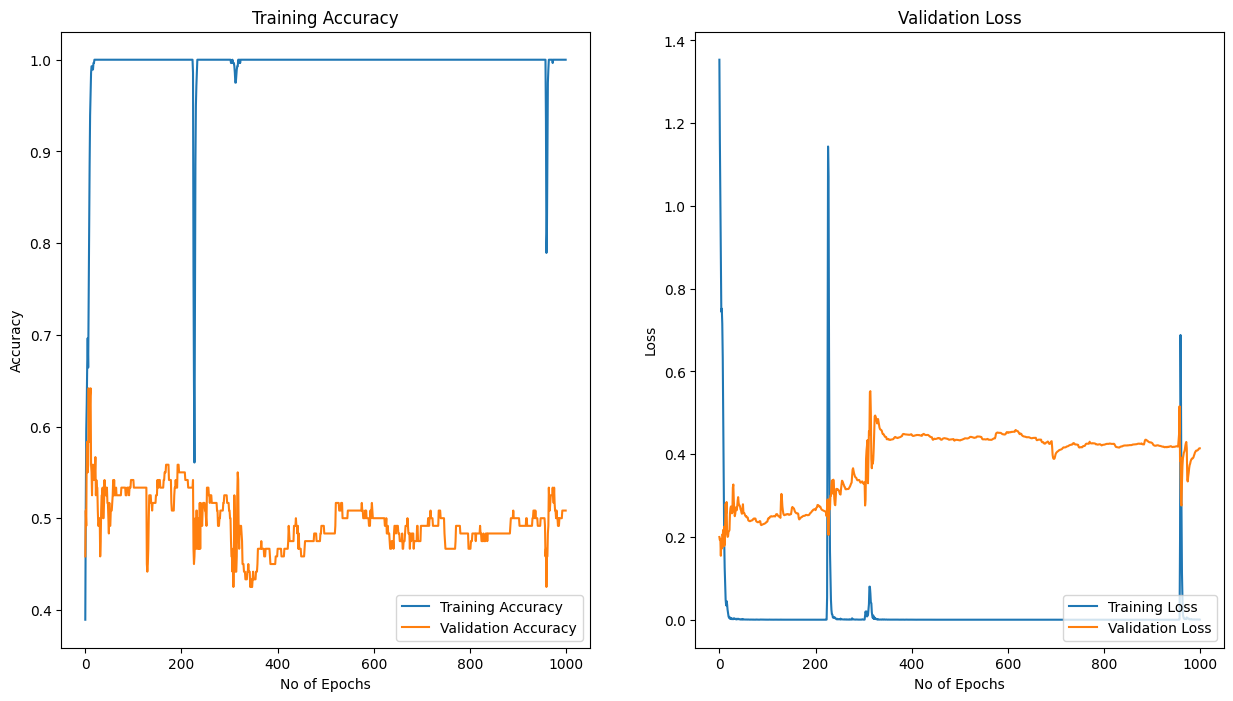

In [7]:
from matplotlib import pyplot as plt
import numpy as np
epochs_range = range(1000) # the x-axis of both the plots wil have the epoch ranges mentioned during each training specification.
# To plot validation accuracy versus each training epoch
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, np.array(val_accuracy), label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No of Epochs')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, np.array(train_loss), label='Training Loss')
plt.plot(epochs_range, np.array(val_loss), label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('No of Epochs')
plt.legend(loc='lower right')
plt.title('Validation Loss')